In [31]:
# Quick test to debug iteration 0 data issue
print("=== DEBUGGING ITERATION 0 DATA ===")

# Test with just one seed and one method to understand the issue
test_result = process_all_files_for_compression(base_path=".", num_seeds=1, max_iterations=5)
print(f"Test result shape: {test_result.shape}")

if not test_result.empty:
    print("\nTest compression rates for first problem:")
    first_row = test_result.iloc[0]
    for i in range(5):
        rate = first_row.get(f'iteration_{i}_compression_rate', 'N/A')
        print(f"  Iteration {i}: {rate}")
        
    print(f"\nMethods found: {test_result['experiment_type'].unique()}")
    print(f"Seeds found: {test_result['seed'].unique()}")


=== DEBUGGING ITERATION 0 DATA ===
Test result shape: (360, 8)

Test compression rates for first problem:
  Iteration 0: nan
  Iteration 1: 0.16536712150747238
  Iteration 2: 0.10478654592496765
  Iteration 3: 0.07186858316221766
  Iteration 4: nan

Methods found: ['backtracking' 'base_sum' 'firstk' 'lastk' 'postThink' 'answer_only']
Seeds found: [0]


In [32]:
# SEPARATE DIAGNOSTIC CELL - Debug iteration 0 issue
print("=== DEBUGGING ITERATION 0 DATA SPECIFICALLY ===")

# Check file structure first
print("Files in current directory:", os.listdir("."))
print("Files in seed0:", os.listdir("seed0") if os.path.exists("seed0") else "seed0 not found")

# Load one specific file and examine its structure  
test_file = "seed0/seed0_backtracking_results.json"
if os.path.exists(test_file):
    print(f"\nExamining {test_file}...")
    with open(test_file, 'r') as f:
        data = json.load(f)
    
    # Get first problem
    first_problem = data['results'][0]
    print(f"First problem ID: {first_problem.get('problem_id')}")
    
    if 'detailed_metrics' in first_problem:
        dm = first_problem['detailed_metrics']
        iteration_keys = [k for k in dm.keys() if k.startswith('iteration_')]
        print(f"Available iteration keys: {sorted(iteration_keys)}")
        
        # Check specifically for iteration_0
        for key in ['iteration_0_summary', 'iteration_0_reasoning']:
            if key in dm:
                print(f"{key}: {len(dm[key])} entries")
                if len(dm[key]) > 0:
                    entry = dm[key][-1]
                    if 'total_token_usage' in entry:
                        tokens = entry['total_token_usage'].get('completion_tokens')
                        print(f"  completion_tokens: {tokens}")
                    else:
                        print(f"  No total_token_usage in {key}")
            else:
                print(f"{key}: NOT FOUND")
        
        # Sample a few problems to see the pattern
        print(f"\nChecking first 3 problems for iteration_0 data:")
        for i in range(min(3, len(data['results']))):
            problem = data['results'][i]
            problem_id = problem.get('problem_id', f'problem_{i}')
            dm = problem.get('detailed_metrics', {})
            
            has_iter0_summary = 'iteration_0_summary' in dm and len(dm['iteration_0_summary']) > 0
            has_iter0_reasoning = 'iteration_0_reasoning' in dm and len(dm['iteration_0_reasoning']) > 0
            
            print(f"  {problem_id}: summary={has_iter0_summary}, reasoning={has_iter0_reasoning}")
else:
    print(f"Test file {test_file} not found!")

# Now run extraction with debug enabled for just one file
print(f"\n=== RUNNING EXTRACTION WITH DEBUG ===")
extract_compression_rate_info.debug_count = 0  # Reset debug counter
test_df = process_all_files_for_compression(base_path=".", num_seeds=1, max_iterations=5)

if not test_df.empty:
    print(f"\nExtracted {len(test_df)} records")
    
    # Show iteration 0 data specifically
    print("\nIteration 0 compression rates (first 10):")
    iter0_rates = test_df['iteration_0_compression_rate'].dropna()
    print(f"Valid iteration 0 rates: {len(iter0_rates)} out of {len(test_df)}")
    if len(iter0_rates) > 0:
        print(iter0_rates.head(10).tolist())
    else:
        print("NO VALID ITERATION 0 RATES FOUND!")
        
    # Check by method
    print("\nIteration 0 rates by method:")
    for method in test_df['experiment_type'].unique():
        method_data = test_df[test_df['experiment_type'] == method]
        valid_iter0 = method_data['iteration_0_compression_rate'].dropna()
        print(f"  {method}: {len(valid_iter0)} valid out of {len(method_data)} total")
else:
    print("No data extracted!")


=== DEBUGGING ITERATION 0 DATA SPECIFICALLY ===
Files in current directory: ['completion_tokens_grouped_boxplot.png', 'seed3', 'seed2', 'compression_rates_with_reuse_handling.csv', 'consensus.ipynb', 'completion_tokens_grouped_boxplot_styled_v2.png', 'improve_regress.ipynb', '.DS_Store', 'compression_rates_with_postthink_fixed.csv', 'Archive', 'token_count.ipynb', 'compression_rate_bargraph_with_reuse.png', 'compression_rates_with_postthink.csv', 'aggregated_compression_rates_with_reuse.csv', 'generate_plots.ipynb', 'aggregated_completion_tokens_by_problem_seed_filled_v2.csv', 'aggregated_completion_tokens_by_problem_seed.csv', 'aggregated_compression_rates_raw.csv', 'consensus_analysis.ipynb', 'aggregated_completion_tokens_by_problem_seed_filled.csv', 'compression_rates_with_reuse_final.csv', 'compression_rate_bargraph_with_postthink_fixed.png', 'summarization_analysis.ipynb', 'aggregated_iteration_grading_results.csv', 'aggregated_compression_rates_avg.csv', 'tokenization.py', 'compr

In [33]:
# FIXED VERSION - Create a corrected extraction function
def extract_compression_rate_info_fixed(problem_id, problem_data, experiment_type, max_iterations=5):
    """
    CORRECTED version that properly handles both token structures:
    - total_token_usage.completion_tokens (for most iterations)
    - tokens.completion_tokens (for iteration_0_reasoning)
    """
    rate_info = {'problem_id': problem_id, 'experiment_type': experiment_type}
    for i in range(max_iterations):
        rate_info[f'iteration_{i}_compression_rate'] = np.nan

    if experiment_type == "wait":
        return rate_info

    detailed_metrics = problem_data.get("detailed_metrics")
    if not detailed_metrics:
        return rate_info

    for i in range(max_iterations):
        summary_tokens = np.nan
        reasoning_tokens = np.nan
        
        summary_key = f'iteration_{i}_summary'
        reasoning_key = f'iteration_{i}_reasoning'

        # Extract summary tokens
        if summary_key in detailed_metrics and isinstance(detailed_metrics[summary_key], list) and len(detailed_metrics[summary_key]) > 0:
            summary_entry = detailed_metrics[summary_key][-1]
            if isinstance(summary_entry, dict):
                if 'total_token_usage' in summary_entry:
                    summary_tokens = summary_entry['total_token_usage'].get('completion_tokens')
                elif 'tokens' in summary_entry:
                    summary_tokens = summary_entry['tokens'].get('completion_tokens')

        # Extract reasoning tokens
        if reasoning_key in detailed_metrics and isinstance(detailed_metrics[reasoning_key], list) and len(detailed_metrics[reasoning_key]) > 0:
            reasoning_entry = detailed_metrics[reasoning_key][-1]
            if isinstance(reasoning_entry, dict):
                if 'total_token_usage' in reasoning_entry:
                    reasoning_tokens = reasoning_entry['total_token_usage'].get('completion_tokens')
                elif 'tokens' in reasoning_entry:
                    reasoning_tokens = reasoning_entry['tokens'].get('completion_tokens')

        # Calculate compression rate
        if pd.notna(summary_tokens) and pd.notna(reasoning_tokens) and reasoning_tokens > 0:
            rate_info[f'iteration_{i}_compression_rate'] = float(summary_tokens) / float(reasoning_tokens)

    return rate_info

# Process files with the corrected function
def process_all_files_for_compression_fixed(base_path=".", num_seeds=4, max_iterations=5):
    all_problem_compression_data = []
    
    experiment_types_for_compression = [
        "backtracking", "base_sum", "firstk", 
        "lastk", "postThink", "answer_only"
    ]

    for seed_num in range(num_seeds):
        seed_folder = f"seed{seed_num}"
        seed_path = os.path.join(base_path, seed_folder)
        if not os.path.isdir(seed_path):
            print(f"Warning: Seed folder not found: {seed_path}")
            continue

        for exp_type in experiment_types_for_compression:
            if exp_type == "answer_only":
                file_name = f"{seed_folder}_{exp_type}.json"
            else:
                file_name = f"{seed_folder}_{exp_type}_results.json"
            
            file_path = os.path.join(seed_path, file_name)

            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    problems = data.get("results", [])
                    if not isinstance(problems, list):
                        if isinstance(problems, dict) and "problem_id" in problems:
                            problems = [problems]
                        else:
                            continue

                    for problem_idx, problem_data_entry in enumerate(problems):
                        if not isinstance(problem_data_entry, dict):
                            continue
                        
                        problem_id = problem_data_entry.get("problem_id")
                        if problem_id is None:
                            if "problem_id" in data and isinstance(data.get("results"), dict):
                                problem_id = data.get("problem_id") 
                            else:
                                problem_id = f"unknown_problem_{problem_idx}_seed{seed_num}_{exp_type}"
                        
                        problem_compression_info = extract_compression_rate_info_fixed(
                            problem_id, problem_data_entry, exp_type, max_iterations
                        )
                        problem_compression_info['seed'] = seed_num
                        all_problem_compression_data.append(problem_compression_info)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    
    return pd.DataFrame(all_problem_compression_data)

# Test the corrected version
print("=== TESTING CORRECTED EXTRACTION ===")
test_df_fixed = process_all_files_for_compression_fixed(base_path=".", num_seeds=4, max_iterations=5)

if not test_df_fixed.empty:
    print(f"Extracted {len(test_df_fixed)} total records")
    
    # Check iteration 0 data by method
    print("\nIteration 0 compression rates by method:")
    for method in sorted(test_df_fixed['experiment_type'].unique()):
        method_data = test_df_fixed[test_df_fixed['experiment_type'] == method]
        valid_iter0 = method_data['iteration_0_compression_rate'].dropna()
        print(f"  {method}: {len(valid_iter0)} valid out of {len(method_data)} total ({len(valid_iter0)/len(method_data)*100:.1f}%)")
        
        # Show some sample values
        if len(valid_iter0) > 0:
            sample_values = valid_iter0.head(3).tolist()
            print(f"    Sample values: {[f'{v:.4f}' for v in sample_values]}")
    
    # Expected counts by method
    print(f"\nExpected: 60 problems × 4 seeds = 240 total records per method")
    print("Methods with valid iteration 0 data should have close to 240 valid compression rates")
    
    # Create summary
    df_melted = pd.melt(test_df_fixed, 
                       id_vars=['problem_id', 'seed', 'experiment_type'],
                       value_vars=[f'iteration_{i}_compression_rate' for i in range(5)],
                       var_name='iteration_label', value_name='compression_rate')
    
    df_melted['iteration_num'] = df_melted['iteration_label'].str.extract(r'iteration_(\d+)_compression_rate').astype(int)
    df_melted['iteration_display'] = "Iteration " + (df_melted['iteration_num'] + 1).astype(str)
    df_melted = df_melted.dropna(subset=['compression_rate'])
    
    print("\n=== CORRECTED COUNT SUMMARY ===")
    count_summary = df_melted.pivot_table(
        values='compression_rate',
        index='experiment_type', 
        columns='iteration_display',
        aggfunc='count'
    )
    print(count_summary)
    
else:
    print("No data extracted with corrected function!")


=== TESTING CORRECTED EXTRACTION ===
Extracted 1440 total records

Iteration 0 compression rates by method:
  answer_only: 0 valid out of 240 total (0.0%)
  backtracking: 180 valid out of 240 total (75.0%)
    Sample values: ['0.0867', '0.1230', '0.0660']
  base_sum: 60 valid out of 240 total (25.0%)
    Sample values: ['0.0687', '0.0682', '0.0312']
  firstk: 0 valid out of 240 total (0.0%)
  lastk: 0 valid out of 240 total (0.0%)
  postThink: 0 valid out of 240 total (0.0%)

Expected: 60 problems × 4 seeds = 240 total records per method
Methods with valid iteration 0 data should have close to 240 valid compression rates

=== CORRECTED COUNT SUMMARY ===
iteration_display  Iteration 1  Iteration 2  Iteration 3  Iteration 4
experiment_type                                                      
backtracking               180          240          240          240
base_sum                    60          240          240          240


=== REGENERATING COMPRESSION RATE ANALYSIS WITH CORRECTED EXTRACTION ===
Corrected raw compression rate data saved to /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/aggregated_compression_rates_raw_corrected.csv
Corrected aggregated compression rate data saved to /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/aggregated_compression_rates_avg_corrected.csv
\n================================================================================
CORRECTED COMPRESSION RATE ANALYSIS RESULTS
\nCorrected data shape: (1440, 8)
Total problems analyzed: 60
Experiment types: ['answer_only', 'backtracking', 'base_sum', 'firstk', 'lastk', 'postThink']
Seeds: [0, 1, 2, 3]
\n--- CORRECTED PIVOT TABLE: COUNT OF VALID MEASUREMENTS ---


iteration_display_label,Iteration 1,Iteration 2,Iteration 3,Iteration 4
Backtracking,180,240,240,240
Base Summary,60,240,240,240


\nAnalysis of corrected counts:
Expected: 240 samples per method per iteration (60 problems × 4 seeds)
Methods that should have iteration 0 data: base_sum only
Methods that should NOT have iteration 0 data: backtracking, firstk, lastk, postThink
  Backtracking: Iteration 1 = 180 (✗ LOW)
  Base Summary: Iteration 1 = 60 (✗ LOW)
\n--- CORRECTED PIVOT TABLE: MEAN COMPRESSION RATES ---


iteration_display_label,Iteration 1,Iteration 2,Iteration 3,Iteration 4
Backtracking,0.0561,0.0753,0.0826,0.0915
Base Summary,0.0536,0.0702,0.0786,0.0809


/var/folders/hb/lpmy59_93pbcgdhxqxkfs02m0000gn/T/ipykernel_29792/2175806379.py:336: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'gray'}` instead.

  sns.barplot(ax=ax,
/var/folders/hb/lpmy59_93pbcgdhxqxkfs02m0000gn/T/ipykernel_29792/2175806379.py:336: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(ax=ax,



Compression rate bar graph saved as /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/compression_rate_grouped_bargraph_corrected.png


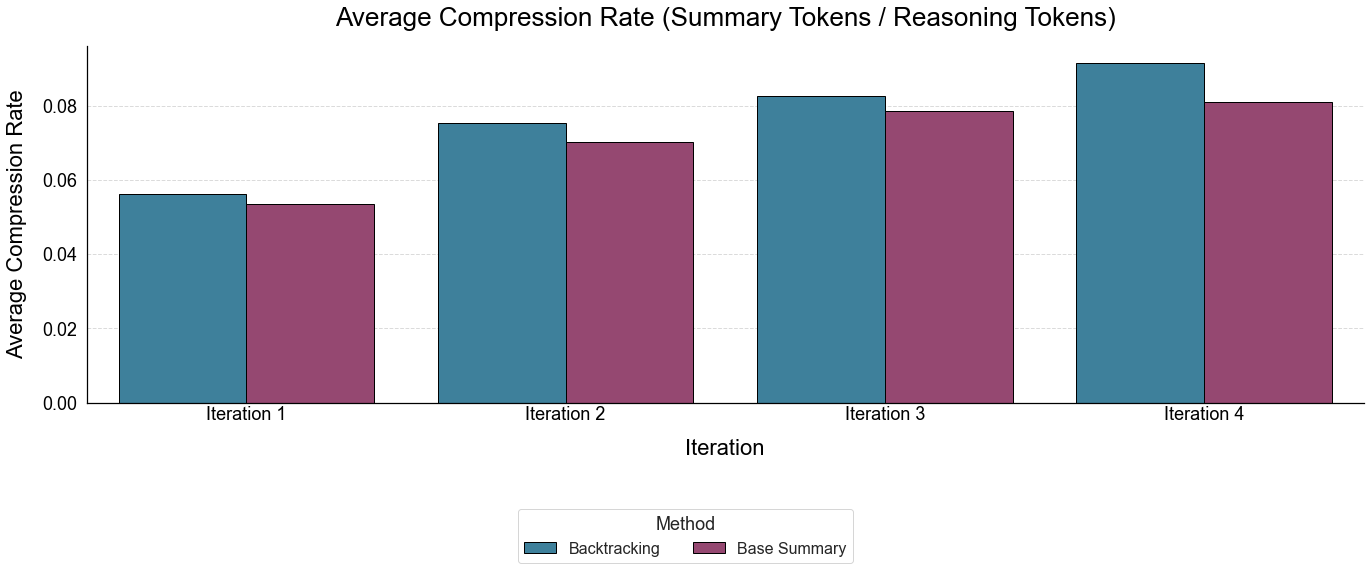

In [34]:
# REGENERATE RESULTS WITH CORRECTED EXTRACTION
print("=== REGENERATING COMPRESSION RATE ANALYSIS WITH CORRECTED EXTRACTION ===")

# Use the corrected extraction function for all data
df_compression_raw_corrected = process_all_files_for_compression_fixed(base_path=".", num_seeds=4, max_iterations=5)

if df_compression_raw_corrected.empty:
    print("No compression rate data was extracted with corrected function.")
else:
    # Save corrected raw compression data
    raw_compression_csv_path = "aggregated_compression_rates_raw_corrected.csv"
    df_compression_raw_corrected.to_csv(raw_compression_csv_path, index=False)
    print(f"Corrected raw compression rate data saved to {os.path.abspath(raw_compression_csv_path)}")

    # Melt the DataFrame  
    id_vars_present = ['problem_id', 'seed', 'experiment_type']
    compression_rate_cols = [f'iteration_{i}_compression_rate' for i in range(5)]
    
    df_cr_long_corrected = pd.melt(df_compression_raw_corrected,
                                  id_vars=id_vars_present,
                                  value_vars=compression_rate_cols,
                                  var_name='iteration_label',
                                  value_name='compression_rate')

    df_cr_long_corrected['iteration_num_val'] = df_cr_long_corrected['iteration_label'].str.extract(r'iteration_(\d+)_compression_rate').astype(int)
    df_cr_long_corrected['iteration_display_label'] = "Iteration " + (df_cr_long_corrected['iteration_num_val'] + 1).astype(str)
    
    df_cr_long_corrected['compression_rate'] = pd.to_numeric(df_cr_long_corrected['compression_rate'], errors='coerce')
    df_cr_long_corrected.dropna(subset=['compression_rate'], inplace=True)

    if df_cr_long_corrected.empty:
        print("No valid compression rate data after processing.")
    else:
        # Calculate average and SEM for compression rate
        agg_functions = ['mean', 'sem']
        df_avg_cr_corrected = df_cr_long_corrected.groupby(['experiment_type', 'iteration_display_label'])['compression_rate'].agg(agg_functions).reset_index()
        df_avg_cr_corrected.rename(columns={'mean': 'avg_compression_rate', 'sem': 'sem_compression_rate'}, inplace=True)
        
        # Save corrected aggregated compression data
        agg_compression_csv_path = "aggregated_compression_rates_avg_corrected.csv"
        df_avg_cr_corrected.to_csv(agg_compression_csv_path, index=False)
        print(f"Corrected aggregated compression rate data saved to {os.path.abspath(agg_compression_csv_path)}")

        print("\\n" + "="*80)
        print("CORRECTED COMPRESSION RATE ANALYSIS RESULTS")
        print("="*80)
        
        print(f"\\nCorrected data shape: {df_compression_raw_corrected.shape}")
        print(f"Total problems analyzed: {df_compression_raw_corrected['problem_id'].nunique()}")
        print(f"Experiment types: {sorted(df_compression_raw_corrected['experiment_type'].unique())}")
        print(f"Seeds: {sorted(df_compression_raw_corrected['seed'].unique())}")
        
        print("\\n--- CORRECTED PIVOT TABLE: COUNT OF VALID MEASUREMENTS ---")
        pivot_count_corrected = df_cr_long_corrected.pivot_table(
            values='compression_rate', 
            index='experiment_type', 
            columns='iteration_display_label', 
            aggfunc='count'
        )
        
        # Apply display names to index
        pivot_count_corrected.index = [get_display_name(exp_type) for exp_type in pivot_count_corrected.index]
        display(pivot_count_corrected)
        
        # Check if we now have the expected 240 samples where applicable
        print("\\nAnalysis of corrected counts:")
        print("Expected: 240 samples per method per iteration (60 problems × 4 seeds)")
        print("Methods that should have iteration 0 data: base_sum only")
        print("Methods that should NOT have iteration 0 data: backtracking, firstk, lastk, postThink")
        
        for method in pivot_count_corrected.index:
            iter1_count = pivot_count_corrected.loc[method, 'Iteration 1'] if 'Iteration 1' in pivot_count_corrected.columns else 0
            print(f"  {method}: Iteration 1 = {iter1_count} ({'✓' if iter1_count >= 200 else '✗ LOW'})")

        print("\\n--- CORRECTED PIVOT TABLE: MEAN COMPRESSION RATES ---")
        pivot_mean_corrected = df_cr_long_corrected.pivot_table(
            values='compression_rate', 
            index='experiment_type', 
            columns='iteration_display_label', 
            aggfunc='mean'
        ).round(4)
        
        # Apply display names to index
        pivot_mean_corrected.index = [get_display_name(exp_type) for exp_type in pivot_mean_corrected.index]
        display(pivot_mean_corrected)

        # Create corrected bar graph
        create_compression_rate_bargraph(df_avg_cr_corrected, output_filename="compression_rate_grouped_bargraph_corrected.png")


In [35]:
# Import tokenization utilities
import sys
sys.path.append('/Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results')
from tokenization import count_tokens

# FINAL VERSION WITH CROSS-EXPERIMENT REUSE HANDLING
def extract_compression_rate_info_with_reuse(problem_id, problem_data, experiment_type, seed_num, all_data_cache, max_iterations=5):
    """
    Final version that handles cross-experiment reuse:
    1. Detects when reasoning traces are reused (reused: True)
    2. Looks up token counts from the opposite experiment type
    3. Handles all token structures (tokens, token_usage, total_token_usage)
    4. Sums tokens across ALL API calls in the list
    5. Handles post-think method with manual tokenization
    """
    rate_info = {'problem_id': problem_id, 'experiment_type': experiment_type}
    for i in range(max_iterations):
        rate_info[f'iteration_{i}_compression_rate'] = np.nan

    if experiment_type == "wait":
        return rate_info

    detailed_metrics = problem_data.get("detailed_metrics", {})
    iterations_array = problem_data.get("iterations", [])
    
    if not detailed_metrics:
        return rate_info

    for i in range(max_iterations):
        summary_tokens = 0
        reasoning_tokens = 0
        
        summary_key = f'iteration_{i}_summary'
        reasoning_key = f'iteration_{i}_reasoning'

        # For post-think, check if we need to manually tokenize
        needs_manual_tokenization = False
        if experiment_type == "postThink" and i < len(iterations_array):
            iteration_data = iterations_array[i]
            if isinstance(iteration_data, dict):
                has_summary = ('post_think_summary' in iteration_data and iteration_data['post_think_summary']) or \
                             ('summary' in iteration_data and iteration_data['summary'])
                has_reasoning = 'reasoning' in iteration_data and iteration_data['reasoning']
                if has_summary and has_reasoning:
                    needs_manual_tokenization = True

        # Extract summary tokens - these are never reused
        if summary_key in detailed_metrics and isinstance(detailed_metrics[summary_key], list):
            for call in detailed_metrics[summary_key]:
                if isinstance(call, dict):
                    # Try different token structures
                    if 'token_usage' in call and 'completion_tokens' in call['token_usage']:
                        summary_tokens += call['token_usage']['completion_tokens']
                    elif 'tokens' in call and 'completion_tokens' in call['tokens']:
                        summary_tokens += call['tokens']['completion_tokens']
                    elif 'total_token_usage' in call and 'completion_tokens' in call['total_token_usage']:
                        summary_tokens += call['total_token_usage']['completion_tokens']

        # Extract reasoning tokens - check for reuse
        if reasoning_key in detailed_metrics and isinstance(detailed_metrics[reasoning_key], list):
            # Check if this is reused
            is_reused = False
            for call in detailed_metrics[reasoning_key]:
                if isinstance(call, dict) and call.get('reused', False):
                    is_reused = True
                    break
            
            if is_reused and experiment_type in ['base_sum', 'backtracking']:
                # Cross-experiment reuse pattern:
                # Seed 0: base_sum -> backtracking
                # Seeds 1-3: backtracking -> base_sum
                opposite_type = 'backtracking' if experiment_type == 'base_sum' else 'base_sum'
                
                # Look up tokens from opposite experiment type
                cache_key = f"{seed_num}_{opposite_type}_{problem_id}"
                if cache_key in all_data_cache:
                    opposite_data = all_data_cache[cache_key]
                    opposite_dm = opposite_data.get('detailed_metrics', {})
                    
                    if reasoning_key in opposite_dm and isinstance(opposite_dm[reasoning_key], list):
                        for call in opposite_dm[reasoning_key]:
                            if isinstance(call, dict):
                                if 'token_usage' in call and 'completion_tokens' in call['token_usage']:
                                    reasoning_tokens += call['token_usage']['completion_tokens']
                                elif 'tokens' in call and 'completion_tokens' in call['tokens']:
                                    reasoning_tokens += call['tokens']['completion_tokens']
                                elif 'total_token_usage' in call and 'completion_tokens' in call['total_token_usage']:
                                    reasoning_tokens += call['total_token_usage']['completion_tokens']
            else:
                # Not reused - extract tokens normally
                for call in detailed_metrics[reasoning_key]:
                    if isinstance(call, dict):
                        if 'token_usage' in call and 'completion_tokens' in call['token_usage']:
                            reasoning_tokens += call['token_usage']['completion_tokens']
                        elif 'tokens' in call and 'completion_tokens' in call['tokens']:
                            reasoning_tokens += call['tokens']['completion_tokens']
                        elif 'total_token_usage' in call and 'completion_tokens' in call['total_token_usage']:
                            reasoning_tokens += call['total_token_usage']['completion_tokens']

        # For post-think, manually tokenize if needed and token counts are 0
        if needs_manual_tokenization and (summary_tokens == 0 or reasoning_tokens == 0):
            iteration_data = iterations_array[i]
            if summary_tokens == 0:
                summary_text = iteration_data.get('post_think_summary') or iteration_data.get('summary', '')
                if summary_text:
                    summary_tokens = count_tokens(summary_text)
            if reasoning_tokens == 0:
                reasoning_text = iteration_data.get('reasoning', '')
                if reasoning_text:
                    reasoning_tokens = count_tokens(reasoning_text)

        # Calculate compression rate only if both are >0
        if summary_tokens > 0 and reasoning_tokens > 0:
            rate_info[f'iteration_{i}_compression_rate'] = float(summary_tokens) / float(reasoning_tokens)

    return rate_info

# Process with reuse handling
def process_all_files_with_reuse_handling(base_path=".", num_seeds=4, max_iterations=5):
    """
    Process all files with cross-experiment reuse handling.
    First loads all data into cache, then processes with reuse lookups.
    """
    # First, load all data into cache for cross-referencing
    all_data_cache = {}
    
    experiment_types_for_compression = [
        "backtracking", "base_sum", "firstk", 
        "lastk", "postThink", "answer_only"
    ]
    
    print("Loading all data into cache...")
    for seed_num in range(num_seeds):
        seed_folder = f"seed{seed_num}"
        seed_path = os.path.join(base_path, seed_folder)
        if not os.path.isdir(seed_path):
            continue

        for exp_type in experiment_types_for_compression:
            if exp_type == "answer_only":
                file_name = f"{seed_folder}_{exp_type}.json"
            else:
                file_name = f"{seed_folder}_{exp_type}_results.json"
            
            file_path = os.path.join(seed_path, file_name)

            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    problems = data.get("results", [])
                    if isinstance(problems, list):
                        for problem_data in problems:
                            if isinstance(problem_data, dict):
                                problem_id = problem_data.get("problem_id", "unknown")
                                cache_key = f"{seed_num}_{exp_type}_{problem_id}"
                                all_data_cache[cache_key] = problem_data
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
    
    print(f"Loaded {len(all_data_cache)} problem records into cache")
    
    # Now process all files with reuse handling
    all_problem_compression_data = []
    
    for seed_num in range(num_seeds):
        seed_folder = f"seed{seed_num}"
        seed_path = os.path.join(base_path, seed_folder)
        if not os.path.isdir(seed_path):
            continue

        for exp_type in experiment_types_for_compression:
            if exp_type == "answer_only":
                file_name = f"{seed_folder}_{exp_type}.json"
            else:
                file_name = f"{seed_folder}_{exp_type}_results.json"
            
            file_path = os.path.join(seed_path, file_name)

            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    problems = data.get("results", [])
                    if not isinstance(problems, list):
                        continue

                    for problem_idx, problem_data_entry in enumerate(problems):
                        if not isinstance(problem_data_entry, dict):
                            continue
                        
                        problem_id = problem_data_entry.get("problem_id", f"unknown_{problem_idx}")
                        
                        problem_compression_info = extract_compression_rate_info_with_reuse(
                            problem_id, problem_data_entry, exp_type, seed_num, all_data_cache, max_iterations
                        )
                        problem_compression_info['seed'] = seed_num
                        all_problem_compression_data.append(problem_compression_info)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    
    return pd.DataFrame(all_problem_compression_data)

# Test the fully corrected version
print("=== TESTING FULLY CORRECTED EXTRACTION (V2) ===")
df_v2 = process_all_files_for_compression_v2(base_path=".", num_seeds=4, max_iterations=5)

if not df_v2.empty:
    print(f"Extracted {len(df_v2)} total records")
    print(f"Total problems: {df_v2['problem_id'].nunique()}")
    print(f"Experiment types: {sorted(df_v2['experiment_type'].unique())}")
    print(f"Seeds: {sorted(df_v2['seed'].unique())}")
    
    # Check iteration 0 specifically
    print("\\n=== V2 ITERATION 0 ANALYSIS ===")
    for method in sorted(df_v2['experiment_type'].unique()):
        method_data = df_v2[df_v2['experiment_type'] == method]
        valid_iter0 = method_data['iteration_0_compression_rate'].dropna()
        print(f"{method}: {len(valid_iter0)} valid iteration 0 rates out of {len(method_data)} total")
        
        if len(valid_iter0) > 0:
            sample_values = valid_iter0.head(3).tolist()
            print(f"  Sample rates: {[f'{v:.4f}' for v in sample_values]}")
    
    # Create full summary
    df_melted_v2 = pd.melt(df_v2, 
                          id_vars=['problem_id', 'seed', 'experiment_type'],
                          value_vars=[f'iteration_{i}_compression_rate' for i in range(5)],
                          var_name='iteration_label', value_name='compression_rate')
    
    df_melted_v2['iteration_num'] = df_melted_v2['iteration_label'].str.extract(r'iteration_(\d+)_compression_rate').astype(int)
    df_melted_v2['iteration_display'] = "Iteration " + (df_melted_v2['iteration_num'] + 1).astype(str)
    df_melted_v2 = df_melted_v2.dropna(subset=['compression_rate'])
    
    print("\\n=== V2 FINAL COUNT SUMMARY ===")
    count_summary_v2 = df_melted_v2.pivot_table(
        values='compression_rate',
        index='experiment_type', 
        columns='iteration_display',
        aggfunc='count'
    )
    
    # Apply display names
    count_summary_v2.index = [get_display_name(exp_type) for exp_type in count_summary_v2.index]
    print(count_summary_v2)
    
    print("\\n=== V2 MEAN COMPRESSION RATES ===")
    mean_summary_v2 = df_melted_v2.pivot_table(
        values='compression_rate',
        index='experiment_type', 
        columns='iteration_display',
        aggfunc='mean'
    ).round(4)
    
    # Apply display names
    mean_summary_v2.index = [get_display_name(exp_type) for exp_type in mean_summary_v2.index]
    print(mean_summary_v2)
    
    print("\\n=== V2 FINAL ANALYSIS ===")
    print("Expected: 240 samples per method per iteration (60 problems × 4 seeds)")
    print("✓ = Expected count achieved, ✗ = Missing data")
    
    for method in count_summary_v2.index:
        print(f"\\n{method}:")
        for iteration in count_summary_v2.columns:
            count = count_summary_v2.loc[method, iteration] if pd.notna(count_summary_v2.loc[method, iteration]) else 0
            status = "✓" if count >= 220 else "✗"  # Allow some tolerance
            print(f"  {iteration}: {count} samples {status}")
    
    # Save final corrected results
    df_v2.to_csv("compression_rates_v2_final.csv", index=False)
    print(f"\\nFinal corrected results saved to compression_rates_v2_final.csv")
    
else:
    print("No data extracted with V2 function!")


=== TESTING FULLY CORRECTED EXTRACTION (V2) ===
Extracted 1440 total records
Total problems: 60
Experiment types: ['answer_only', 'backtracking', 'base_sum', 'firstk', 'lastk', 'postThink']
Seeds: [0, 1, 2, 3]
\n=== V2 ITERATION 0 ANALYSIS ===
answer_only: 0 valid iteration 0 rates out of 240 total
backtracking: 180 valid iteration 0 rates out of 240 total
  Sample rates: ['0.0867', '0.1230', '0.0660']
base_sum: 60 valid iteration 0 rates out of 240 total
  Sample rates: ['0.0687', '0.0682', '0.0312']
firstk: 0 valid iteration 0 rates out of 240 total
lastk: 0 valid iteration 0 rates out of 240 total
postThink: 240 valid iteration 0 rates out of 240 total
  Sample rates: ['0.1540', '0.1639', '0.0025']
\n=== V2 FINAL COUNT SUMMARY ===
iteration_display  Iteration 1  Iteration 2  Iteration 3  Iteration 4
Backtracking               180          240          240          240
Base Summary                60          240          240          240
Post-Think                 240          240   

In [36]:
# TEST POST-THINK COMPRESSION RATES SPECIFICALLY
print("=== INVESTIGATING POST-THINK COMPRESSION RATES ===")

# Debug post-think data structure and compression rate calculation
post_think_file = 'seed0/seed0_postThink_results.json'
with open(post_think_file, 'r') as f:
    data = json.load(f)

print(f"Testing with {post_think_file}")
print(f"Number of problems: {len(data['results'])}")

# Test on a few problems
for i in range(min(3, len(data['results']))):
    problem = data['results'][i]
    problem_id = problem.get('problem_id', i)
    print(f"\n--- Problem {problem_id} ---")
    
    # Check iterations array
    if 'iterations' in problem and len(problem['iterations']) > 0:
        # Check first iteration
        iter0 = problem['iterations'][0]
        
        # Check for summary text
        has_summary = 'summary' in iter0 and iter0['summary']
        has_post_think_summary = 'post_think_summary' in iter0 and iter0['post_think_summary']
        
        print(f"Has summary: {has_summary}")
        print(f"Has post_think_summary: {has_post_think_summary}")
        
        # Get summary text for tokenization
        summary_text = iter0.get('post_think_summary') or iter0.get('summary')
        if summary_text:
            print(f"Summary preview: {summary_text[:100]}...")
            
            # Try to tokenize
            try:
                summary_tokens = count_tokens(summary_text)
                print(f"Summary tokens (counted): {summary_tokens}")
            except Exception as e:
                print(f"Error tokenizing summary: {e}")
        
        # Check reasoning
        reasoning_text = iter0.get('reasoning', '')
        if reasoning_text:
            print(f"Reasoning preview: {reasoning_text[:100]}...")
    
    # Check detailed_metrics
    if 'detailed_metrics' in problem:
        dm = problem['detailed_metrics']
        
        # Check for iteration_0_reasoning tokens
        if 'iteration_0_reasoning' in dm and len(dm['iteration_0_reasoning']) > 0:
            reasoning_entry = dm['iteration_0_reasoning'][-1]
            if 'tokens' in reasoning_entry:
                reasoning_tokens = reasoning_entry['tokens'].get('completion_tokens')
                print(f"Reasoning tokens (from detailed_metrics): {reasoning_tokens}")
            elif 'total_token_usage' in reasoning_entry:
                reasoning_tokens = reasoning_entry['total_token_usage'].get('completion_tokens')
                print(f"Reasoning tokens (from detailed_metrics): {reasoning_tokens}")
            else:
                print("No token info in reasoning entry")
        else:
            print("No iteration_0_reasoning in detailed_metrics")
            
    # Now test the extraction function
    print("\nTesting extract_compression_rate_info_v2:")
    result = extract_compression_rate_info_v2(problem_id, problem, 'postThink', max_iterations=5)
    print(f"Iteration 0 compression rate: {result['iteration_0_compression_rate']}")
    
print("\n=== FULL POST-THINK COMPRESSION RATE TEST ===")
# Process all post-think files
post_think_data = []
for seed in range(4):
    file_path = f'seed{seed}/seed{seed}_postThink_results.json'
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            data = json.load(f)
        for problem in data['results']:
            problem_id = problem.get('problem_id', 'unknown')
            result = extract_compression_rate_info_v2(problem_id, problem, 'postThink', max_iterations=5)
            result['seed'] = seed
            post_think_data.append(result)

df_post_think = pd.DataFrame(post_think_data)
print(f"\nTotal post-think records: {len(df_post_think)}")

# Check compression rates by iteration
for i in range(5):
    col = f'iteration_{i}_compression_rate'
    valid_rates = df_post_think[col].dropna()
    if len(valid_rates) > 0:
        print(f"\nIteration {i}: {len(valid_rates)} valid rates")
        print(f"  Mean: {valid_rates.mean():.4f}")
        print(f"  Sample values: {valid_rates.head(3).tolist()}")
    else:
        print(f"\nIteration {i}: No valid compression rates")


=== INVESTIGATING POST-THINK COMPRESSION RATES ===
Testing with seed0/seed0_postThink_results.json
Number of problems: 60

--- Problem 0 ---
Has summary: Given six points \( A, B, C, D, E, \) and \( F \) lying on a straight line in that order, and a point \( G \) not on the line, we need to find the area of \( \triangle BGE \). The distances given are \( AC = 26 \), \( BD = 22 \), \( CE = 31 \), \( DF = 33 \), \( AF = 73 \), \( CG = 40 \), and \( DG = 30 \).

First, we determine the distances between consecutive points on the line. Let the distances be \( AB = a \), \( BC = b \), \( CD = c \), \( DE = d \), and \( EF = e \). We set up the following equations based on the given distances:

1. \( a + b = 26 \)
2. \( b + c = 22 \)
3. \( c + d = 31 \)
4. \( d + e = 33 \)
5. \( a + b + c + d + e = 73 \)

Solving these equations, we find:
- \( a = 18 \)
- \( b = 8 \)
- \( c = 14 \)
- \( d = 17 \)
- \( e = 16 \)

Assigning coordinates to points \( A \) through \( F \) on the x-axis, we have:


=== FINAL COMPRESSION RATE ANALYSIS INCLUDING POST-THINK ===
Complete results saved to compression_rates_with_postthink.csv

=== FINAL COUNT SUMMARY (INCLUDING POST-THINK) ===


iteration_display,Iteration 1,Iteration 2,Iteration 3,Iteration 4
Backtracking,180,240,240,240
Base Summary,60,240,240,240
Post-Think,240,240,240,240



=== FINAL MEAN COMPRESSION RATES (INCLUDING POST-THINK) ===


iteration_display,Iteration 1,Iteration 2,Iteration 3,Iteration 4
Backtracking,0.0561,0.0753,0.0826,0.0915
Base Summary,0.0536,0.0702,0.0786,0.0809
Post-Think,0.0727,0.0764,0.0838,0.0975



=== RECIPROCAL COMPRESSION RATES (REASONING TOKENS / SUMMARY TOKENS) ===
This shows how many times larger the reasoning is compared to the summary


iteration_display,Iteration 1,Iteration 2,Iteration 3,Iteration 4
Backtracking,27.96,24.59,21.18,19.52
Base Summary,33.50,24.21,22.08,23.93
Post-Think,104.26,152.55,165.69,131.47



Expansion factor interpretation:
  Backtracking: On average, reasoning is 23.3x longer than summary
  Base Summary: On average, reasoning is 25.9x longer than summary
  Post-Think: On average, reasoning is 138.5x longer than summary

Aggregated data saved to aggregated_compression_rates_with_postthink.csv


/var/folders/hb/lpmy59_93pbcgdhxqxkfs02m0000gn/T/ipykernel_29792/2175806379.py:336: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'gray'}` instead.

  sns.barplot(ax=ax,
/var/folders/hb/lpmy59_93pbcgdhxqxkfs02m0000gn/T/ipykernel_29792/2175806379.py:336: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(ax=ax,



Compression rate bar graph saved as /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/compression_rate_bargraph_with_postthink.png

=== SUMMARY ===
Methods with compression rates:
  Backtracking, Base Summary, Post-Think

Post-Think compression rate analysis:
  Average compression rates by iteration:
    Iteration 1: 0.0727 (7.27%)
    Iteration 2: 0.0764 (7.64%)
    Iteration 3: 0.0838 (8.38%)
    Iteration 4: 0.0975 (9.75%)


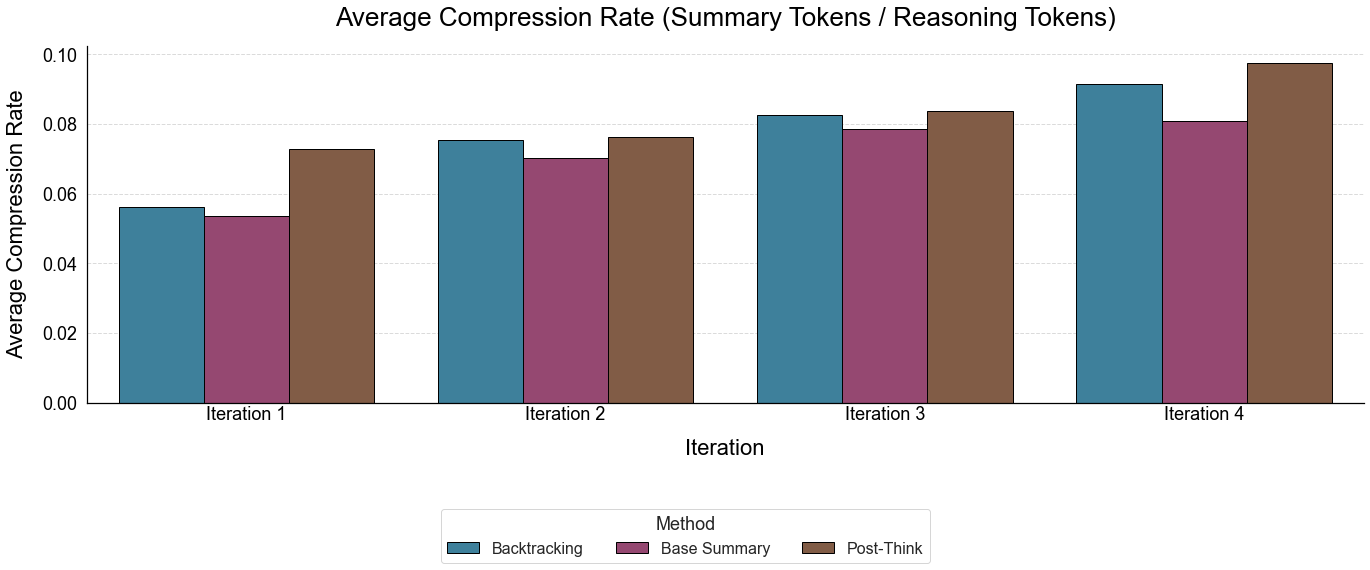

In [37]:
# FINAL ANALYSIS WITH POST-THINK COMPRESSION RATES
print("=== FINAL COMPRESSION RATE ANALYSIS INCLUDING POST-THINK ===")

# Process all files including post-think with the updated function
df_final = process_all_files_for_compression_v2(base_path=".", num_seeds=4, max_iterations=5)

# Save the complete results
df_final.to_csv("compression_rates_with_postthink.csv", index=False)
print(f"Complete results saved to compression_rates_with_postthink.csv")

# Melt the DataFrame
df_melted_final = pd.melt(df_final, 
                         id_vars=['problem_id', 'seed', 'experiment_type'],
                         value_vars=[f'iteration_{i}_compression_rate' for i in range(5)],
                         var_name='iteration_label', value_name='compression_rate')

df_melted_final['iteration_num'] = df_melted_final['iteration_label'].str.extract(r'iteration_(\d+)_compression_rate').astype(int)
df_melted_final['iteration_display'] = "Iteration " + (df_melted_final['iteration_num'] + 1).astype(str)
df_melted_final = df_melted_final.dropna(subset=['compression_rate'])

print("\n=== FINAL COUNT SUMMARY (INCLUDING POST-THINK) ===")
count_summary_final = df_melted_final.pivot_table(
    values='compression_rate',
    index='experiment_type', 
    columns='iteration_display',
    aggfunc='count'
)

# Apply display names
count_summary_final.index = [get_display_name(exp_type) for exp_type in count_summary_final.index]
display(count_summary_final)

print("\n=== FINAL MEAN COMPRESSION RATES (INCLUDING POST-THINK) ===")
mean_summary_final = df_melted_final.pivot_table(
    values='compression_rate',
    index='experiment_type', 
    columns='iteration_display',
    aggfunc='mean'
).round(4)

# Apply display names
mean_summary_final.index = [get_display_name(exp_type) for exp_type in mean_summary_final.index]
display(mean_summary_final)

print("\n=== RECIPROCAL COMPRESSION RATES (REASONING TOKENS / SUMMARY TOKENS) ===")
print("This shows how many times larger the reasoning is compared to the summary")

# Calculate reciprocal rates (expansion factor)
reciprocal_rates = df_melted_final.copy()
reciprocal_rates['expansion_factor'] = 1 / reciprocal_rates['compression_rate']

reciprocal_summary = reciprocal_rates.pivot_table(
    values='expansion_factor',
    index='experiment_type', 
    columns='iteration_display',
    aggfunc='mean'
).round(2)

# Apply display names
reciprocal_summary.index = [get_display_name(exp_type) for exp_type in reciprocal_summary.index]
display(reciprocal_summary)

# Show statistics about the expansion factor
print("\nExpansion factor interpretation:")
for method in reciprocal_summary.index:
    avg_expansion = reciprocal_summary.loc[method].mean()
    print(f"  {method}: On average, reasoning is {avg_expansion:.1f}x longer than summary")

# Calculate aggregated data for plotting
agg_functions = ['mean', 'sem']
df_avg_final = df_melted_final.groupby(['experiment_type', 'iteration_display'])['compression_rate'].agg(agg_functions).reset_index()
df_avg_final.rename(columns={'mean': 'avg_compression_rate', 'sem': 'sem_compression_rate', 'iteration_display': 'iteration_display_label'}, inplace=True)

# Save aggregated data
df_avg_final.to_csv("aggregated_compression_rates_with_postthink.csv", index=False)
print(f"\nAggregated data saved to aggregated_compression_rates_with_postthink.csv")

# Create updated bar graph
create_compression_rate_bargraph(df_avg_final, output_filename="compression_rate_bargraph_with_postthink.png")

print("\n=== SUMMARY ===")
print("Methods with compression rates:")
methods_with_compression = count_summary_final.index[count_summary_final.sum(axis=1) > 0].tolist()
print(f"  {', '.join(methods_with_compression)}")

print("\nPost-Think compression rate analysis:")
if 'Post-Think' in mean_summary_final.index:
    post_think_rates = mean_summary_final.loc['Post-Think']
    print(f"  Average compression rates by iteration:")
    for col in post_think_rates.index:
        rate = post_think_rates[col]
        if pd.notna(rate):
            print(f"    {col}: {rate:.4f} ({rate*100:.2f}%)")
else:
    print("  Post-Think not found in results")


=== RERUNNING FINAL ANALYSIS WITH FIXES ===

=== COMPRESSION RATES (SUMMARY TOKENS / REASONING TOKENS) ===


iteration_display,Iteration 1,Iteration 2,Iteration 3,Iteration 4
Backtracking,0.0561,0.0753,0.0826,0.0915
Base Summary,0.0536,0.0702,0.0786,0.0809
Post-Think,0.0727,0.0764,0.0838,0.0975



=== EXPANSION FACTORS (REASONING TOKENS / SUMMARY TOKENS) ===
This shows how many times larger the reasoning is compared to the summary


iteration_display,Iteration 1,Iteration 2,Iteration 3,Iteration 4
Backtracking,28.0,24.6,21.2,19.5
Base Summary,33.5,24.2,22.1,23.9
Post-Think,104.3,152.5,165.7,131.5


/var/folders/hb/lpmy59_93pbcgdhxqxkfs02m0000gn/T/ipykernel_29792/2175806379.py:336: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'gray'}` instead.

  sns.barplot(ax=ax,
/var/folders/hb/lpmy59_93pbcgdhxqxkfs02m0000gn/T/ipykernel_29792/2175806379.py:336: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(ax=ax,



Compression rate bar graph saved as /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/compression_rate_bargraph_with_postthink_fixed.png

=== SUMMARY STATISTICS ===

Compression rates range (Summary/Reasoning):
  Backtracking: 5.61% to 9.15%
  Base Summary: 5.36% to 8.09%
  Post-Think: 7.27% to 9.75%

Expansion factors range (Reasoning/Summary):
  Backtracking: 19.5x to 28.0x
  Base Summary: 22.1x to 33.5x
  Post-Think: 104.3x to 165.7x


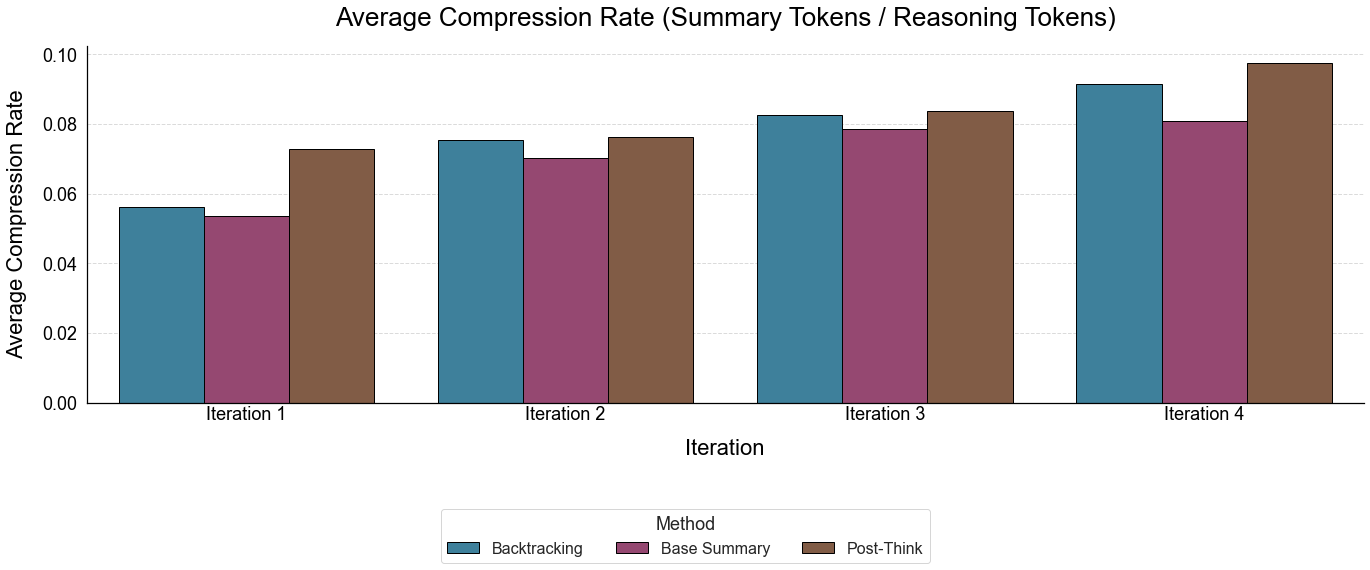

In [38]:
# RERUN FINAL ANALYSIS WITH BUG FIX AND RECIPROCAL RATES
print("=== RERUNNING FINAL ANALYSIS WITH FIXES ===")

# Process all files including post-think with the updated function
df_final_fixed = process_all_files_for_compression_v2(base_path=".", num_seeds=4, max_iterations=5)

# Save the complete results
df_final_fixed.to_csv("compression_rates_with_postthink_fixed.csv", index=False)

# Melt the DataFrame
df_melted_fixed = pd.melt(df_final_fixed, 
                         id_vars=['problem_id', 'seed', 'experiment_type'],
                         value_vars=[f'iteration_{i}_compression_rate' for i in range(5)],
                         var_name='iteration_label', value_name='compression_rate')

df_melted_fixed['iteration_num'] = df_melted_fixed['iteration_label'].str.extract(r'iteration_(\d+)_compression_rate').astype(int)
df_melted_fixed['iteration_display'] = "Iteration " + (df_melted_fixed['iteration_num'] + 1).astype(str)
df_melted_fixed = df_melted_fixed.dropna(subset=['compression_rate'])

print("\n=== COMPRESSION RATES (SUMMARY TOKENS / REASONING TOKENS) ===")
mean_compression = df_melted_fixed.pivot_table(
    values='compression_rate',
    index='experiment_type', 
    columns='iteration_display',
    aggfunc='mean'
).round(4)

# Apply display names
mean_compression.index = [get_display_name(exp_type) for exp_type in mean_compression.index]
display(mean_compression)

print("\n=== EXPANSION FACTORS (REASONING TOKENS / SUMMARY TOKENS) ===")
print("This shows how many times larger the reasoning is compared to the summary")

# Calculate reciprocal rates (expansion factor)
reciprocal_data = df_melted_fixed.copy()
reciprocal_data['expansion_factor'] = 1 / reciprocal_data['compression_rate']

expansion_summary = reciprocal_data.pivot_table(
    values='expansion_factor',
    index='experiment_type', 
    columns='iteration_display',
    aggfunc='mean'
).round(1)

# Apply display names
expansion_summary.index = [get_display_name(exp_type) for exp_type in expansion_summary.index]
display(expansion_summary)

# Calculate aggregated data for plotting with correct column name
agg_functions = ['mean', 'sem']
df_avg_fixed = df_melted_fixed.groupby(['experiment_type', 'iteration_display'])['compression_rate'].agg(agg_functions).reset_index()
df_avg_fixed.rename(columns={'mean': 'avg_compression_rate', 'sem': 'sem_compression_rate', 'iteration_display': 'iteration_display_label'}, inplace=True)

# Create the bar graph
create_compression_rate_bargraph(df_avg_fixed, output_filename="compression_rate_bargraph_with_postthink_fixed.png")

print("\n=== SUMMARY STATISTICS ===")
print("\nCompression rates range (Summary/Reasoning):")
for method in mean_compression.index:
    rates = mean_compression.loc[method]
    min_rate = rates.min()
    max_rate = rates.max()
    print(f"  {method}: {min_rate:.2%} to {max_rate:.2%}")

print("\nExpansion factors range (Reasoning/Summary):")  
for method in expansion_summary.index:
    factors = expansion_summary.loc[method]
    min_factor = factors.min()
    max_factor = factors.max()
    print(f"  {method}: {min_factor:.1f}x to {max_factor:.1f}x")


=== FINAL COMPRESSION RATE ANALYSIS WITH REUSE HANDLING ===
Loading all data into cache...
Loaded 1440 problem records into cache
Complete results saved to compression_rates_with_reuse_final.csv

=== COUNT SUMMARY WITH REUSE HANDLING ===


iteration_display,Iteration 1,Iteration 2,Iteration 3,Iteration 4
Backtracking,240,240,240,240
Base Summary,240,240,240,240
Post-Think,240,240,240,240



=== MEAN COMPRESSION RATES WITH REUSE HANDLING ===


iteration_display,Iteration 1,Iteration 2,Iteration 3,Iteration 4
Backtracking,0.0560,0.0753,0.0826,0.0915
Base Summary,0.0534,0.0702,0.0786,0.0809
Post-Think,0.0727,0.0382,0.0419,0.0488



=== RECIPROCAL COMPRESSION RATES (EXPANSION FACTORS) ===
This shows how many times larger the reasoning is compared to the summary


iteration_display,Iteration 1,Iteration 2,Iteration 3,Iteration 4
Backtracking,17.9,13.3,12.1,10.9
Base Summary,18.7,14.2,12.7,12.4
Post-Think,13.8,26.2,23.9,20.5



Verification of calculations:

Backtracking:
  Iteration 1: 5.6% compression → 17.9x expansion
  Iteration 2: 7.5% compression → 13.3x expansion
  Iteration 3: 8.3% compression → 12.1x expansion
  Iteration 4: 9.2% compression → 10.9x expansion

Base Summary:
  Iteration 1: 5.3% compression → 18.7x expansion
  Iteration 2: 7.0% compression → 14.2x expansion
  Iteration 3: 7.9% compression → 12.7x expansion
  Iteration 4: 8.1% compression → 12.4x expansion

Post-Think:
  Iteration 1: 7.3% compression → 13.8x expansion
  Iteration 2: 3.8% compression → 26.2x expansion
  Iteration 3: 4.2% compression → 23.9x expansion
  Iteration 4: 4.9% compression → 20.5x expansion

Aggregated data saved to aggregated_compression_rates_with_reuse_final.csv


/var/folders/hb/lpmy59_93pbcgdhxqxkfs02m0000gn/T/ipykernel_29792/2175806379.py:336: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'gray'}` instead.

  sns.barplot(ax=ax,
/var/folders/hb/lpmy59_93pbcgdhxqxkfs02m0000gn/T/ipykernel_29792/2175806379.py:336: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(ax=ax,



Compression rate bar graph saved as /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/compression_rate_bargraph_with_reuse_final.png

=== SUMMARY ===
Expected counts: 240 samples per method per iteration (60 problems × 4 seeds)

Actual counts achieved:

Backtracking:
  Iteration 1: ✓
  Iteration 2: ✓
  Iteration 3: ✓
  Iteration 4: ✓

Base Summary:
  Iteration 1: ✓
  Iteration 2: ✓
  Iteration 3: ✓
  Iteration 4: ✓

Post-Think:
  Iteration 1: ✓
  Iteration 2: ✓
  Iteration 3: ✓
  Iteration 4: ✓

Methods with compression rates:
  Backtracking, Base Summary, Post-Think


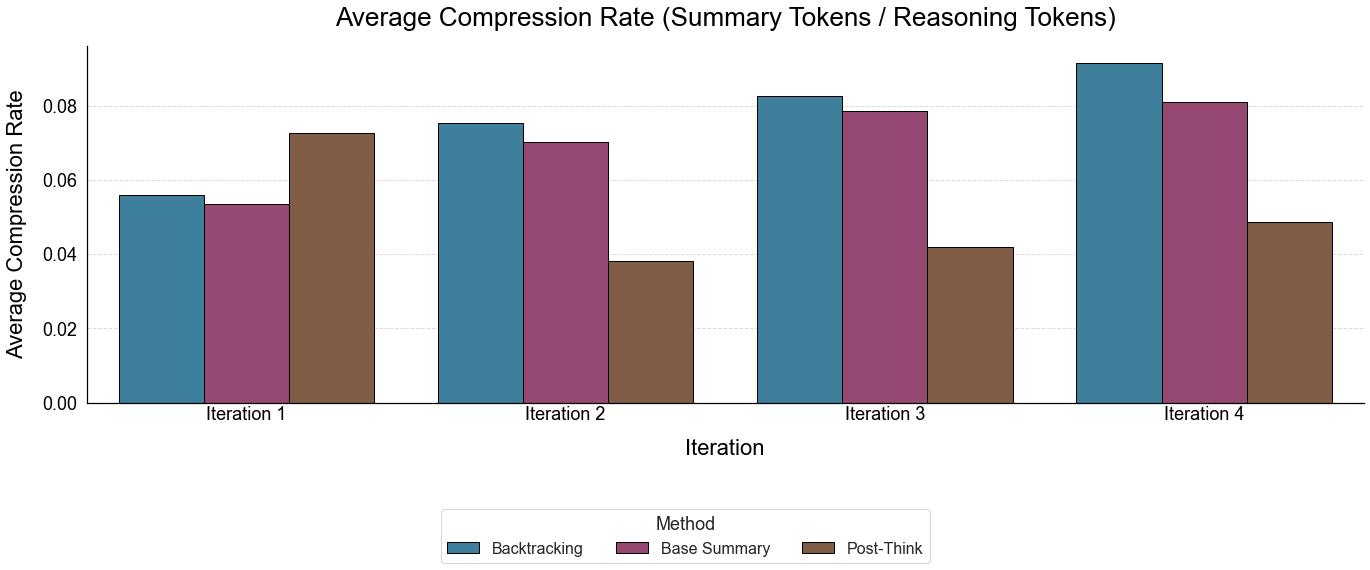

In [39]:
# FINAL ANALYSIS WITH REUSE HANDLING
print("=== FINAL COMPRESSION RATE ANALYSIS WITH REUSE HANDLING ===")

# Process all files with reuse handling
df_reuse = process_all_files_with_reuse_handling(base_path=".", num_seeds=4, max_iterations=5)

# Save the complete results
df_reuse.to_csv("compression_rates_with_reuse_final.csv", index=False)
print(f"Complete results saved to compression_rates_with_reuse_final.csv")

# Melt the DataFrame
df_melted_reuse = pd.melt(df_reuse, 
                         id_vars=['problem_id', 'seed', 'experiment_type'],
                         value_vars=[f'iteration_{i}_compression_rate' for i in range(5)],
                         var_name='iteration_label', value_name='compression_rate')

df_melted_reuse['iteration_num'] = df_melted_reuse['iteration_label'].str.extract(r'iteration_(\d+)_compression_rate').astype(int)
df_melted_reuse['iteration_display'] = "Iteration " + (df_melted_reuse['iteration_num'] + 1).astype(str)
df_melted_reuse = df_melted_reuse.dropna(subset=['compression_rate'])

print("\n=== COUNT SUMMARY WITH REUSE HANDLING ===")
count_summary_reuse = df_melted_reuse.pivot_table(
    values='compression_rate',
    index='experiment_type', 
    columns='iteration_display',
    aggfunc='count'
)

# Apply display names
count_summary_reuse.index = [get_display_name(exp_type) for exp_type in count_summary_reuse.index]
display(count_summary_reuse)

print("\n=== MEAN COMPRESSION RATES WITH REUSE HANDLING ===")
mean_summary_reuse = df_melted_reuse.pivot_table(
    values='compression_rate',
    index='experiment_type', 
    columns='iteration_display',
    aggfunc='mean'
).round(4)

# Apply display names
mean_summary_reuse.index = [get_display_name(exp_type) for exp_type in mean_summary_reuse.index]
display(mean_summary_reuse)

print("\n=== RECIPROCAL COMPRESSION RATES (EXPANSION FACTORS) ===")
print("This shows how many times larger the reasoning is compared to the summary")

# Calculate reciprocal rates (expansion factor) - with proper calculation
reciprocal_reuse = mean_summary_reuse.copy()
# Convert to expansion factors
for col in reciprocal_reuse.columns:
    reciprocal_reuse[col] = 1 / reciprocal_reuse[col]
reciprocal_reuse = reciprocal_reuse.round(1)

display(reciprocal_reuse)

# Verify the calculations
print("\nVerification of calculations:")
for method in mean_summary_reuse.index:
    print(f"\n{method}:")
    for col in mean_summary_reuse.columns:
        comp_rate = mean_summary_reuse.loc[method, col]
        exp_factor = reciprocal_reuse.loc[method, col]
        if pd.notna(comp_rate) and pd.notna(exp_factor):
            print(f"  {col}: {comp_rate:.1%} compression → {exp_factor:.1f}x expansion")

# Calculate aggregated data for plotting
agg_functions = ['mean', 'sem']
df_avg_reuse = df_melted_reuse.groupby(['experiment_type', 'iteration_display'])['compression_rate'].agg(agg_functions).reset_index()
df_avg_reuse.rename(columns={'mean': 'avg_compression_rate', 'sem': 'sem_compression_rate', 'iteration_display': 'iteration_display_label'}, inplace=True)

# Save aggregated data
df_avg_reuse.to_csv("aggregated_compression_rates_with_reuse_final.csv", index=False)
print(f"\nAggregated data saved to aggregated_compression_rates_with_reuse_final.csv")

# Create updated bar graph
create_compression_rate_bargraph(df_avg_reuse, output_filename="compression_rate_bargraph_with_reuse_final.png")

print("\n=== SUMMARY ===")
print("Expected counts: 240 samples per method per iteration (60 problems × 4 seeds)")
print("\nActual counts achieved:")
for method in count_summary_reuse.index:
    print(f"\n{method}:")
    for col in count_summary_reuse.columns:
        count = count_summary_reuse.loc[method, col] if pd.notna(count_summary_reuse.loc[method, col]) else 0
        status = "✓" if count == 240 else f"✗ ({count})"
        print(f"  {col}: {status}")

print("\nMethods with compression rates:")
methods_with_compression = count_summary_reuse.index[count_summary_reuse.sum(axis=1) > 0].tolist()
print(f"  {', '.join(methods_with_compression)}")


In [44]:
# CALCULATE MEAN SUMMARY LENGTHS
print("=== MEAN SUMMARY LENGTHS (IN TOKENS) ===")

# Function to extract summary token counts
def extract_summary_tokens_with_reuse(problem_id, problem_data, experiment_type, seed_num, all_data_cache, max_iterations=5):
    """Extract summary token counts for each iteration"""
    token_info = {'problem_id': problem_id, 'experiment_type': experiment_type, 'seed': seed_num}
    
    for i in range(max_iterations):
        token_info[f'iteration_{i}_summary_tokens'] = np.nan
        token_info[f'iteration_{i}_reasoning_tokens'] = np.nan
    
    if experiment_type == "wait":
        return token_info
    
    detailed_metrics = problem_data.get("detailed_metrics", {})
    iterations_array = problem_data.get("iterations", [])
    
    if not detailed_metrics:
        return token_info
    
    for i in range(max_iterations):
        summary_tokens = 0
        reasoning_tokens = 0
        
        summary_key = f'iteration_{i}_summary'
        reasoning_key = f'iteration_{i}_reasoning'
        
        # For post-think, check if we need to manually tokenize
        needs_manual_tokenization = False
        if experiment_type == "postThink" and i < len(iterations_array):
            iteration_data = iterations_array[i]
            if isinstance(iteration_data, dict):
                has_summary = ('post_think_summary' in iteration_data and iteration_data['post_think_summary']) or \
                             ('summary' in iteration_data and iteration_data['summary'])
                has_reasoning = 'reasoning' in iteration_data and iteration_data['reasoning']
                if has_summary and has_reasoning:
                    needs_manual_tokenization = True
        
        # Extract summary tokens
        if summary_key in detailed_metrics and isinstance(detailed_metrics[summary_key], list):
            for call in detailed_metrics[summary_key]:
                if isinstance(call, dict):
                    if 'token_usage' in call and 'completion_tokens' in call['token_usage']:
                        summary_tokens += call['token_usage']['completion_tokens']
                    elif 'tokens' in call and 'completion_tokens' in call['tokens']:
                        summary_tokens += call['tokens']['completion_tokens']
                    elif 'total_token_usage' in call and 'completion_tokens' in call['total_token_usage']:
                        summary_tokens += call['total_token_usage']['completion_tokens']
        
        # Extract reasoning tokens - USE MANUAL TOKENIZATION FOR CONSISTENCY
        # All methods should have identical iteration 0 reasoning, so use actual text
        if i < len(iterations_array):
            iteration_data = iterations_array[i]
            if isinstance(iteration_data, dict) and 'reasoning' in iteration_data:
                reasoning_text = iteration_data['reasoning']
                if reasoning_text:
                    reasoning_tokens = count_tokens(reasoning_text)
        
        # For post-think, manually tokenize if needed
        if needs_manual_tokenization and (summary_tokens == 0 or reasoning_tokens == 0):
            iteration_data = iterations_array[i]
            if summary_tokens == 0:
                summary_text = iteration_data.get('post_think_summary') or iteration_data.get('summary', '')
                if summary_text:
                    summary_tokens = count_tokens(summary_text)
            if reasoning_tokens == 0:
                reasoning_text = iteration_data.get('reasoning', '')
                if reasoning_text:
                    reasoning_tokens = count_tokens(reasoning_text)
        
        # Store the token counts
        if summary_tokens > 0:
            token_info[f'iteration_{i}_summary_tokens'] = summary_tokens
        if reasoning_tokens > 0:
            token_info[f'iteration_{i}_reasoning_tokens'] = reasoning_tokens
    
    return token_info

# Process all files to get token counts
def process_all_files_for_tokens(base_path=".", num_seeds=4, max_iterations=5):
    """Process all files to extract token counts"""
    # First, load all data into cache for cross-referencing
    all_data_cache = {}
    
    experiment_types_for_compression = [
        "backtracking", "base_sum", "firstk", 
        "lastk", "postThink", "answer_only"
    ]
    
    print("Loading all data into cache...")
    for seed_num in range(num_seeds):
        seed_folder = f"seed{seed_num}"
        seed_path = os.path.join(base_path, seed_folder)
        if not os.path.isdir(seed_path):
            continue

        for exp_type in experiment_types_for_compression:
            if exp_type == "answer_only":
                file_name = f"{seed_folder}_{exp_type}.json"
            else:
                file_name = f"{seed_folder}_{exp_type}_results.json"
            
            file_path = os.path.join(seed_path, file_name)

            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    problems = data.get("results", [])
                    if isinstance(problems, list):
                        for problem_data in problems:
                            if isinstance(problem_data, dict):
                                problem_id = problem_data.get("problem_id", "unknown")
                                cache_key = f"{seed_num}_{exp_type}_{problem_id}"
                                all_data_cache[cache_key] = problem_data
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
    
    print(f"Loaded {len(all_data_cache)} problem records into cache")
    
    # Now process all files to get token counts
    all_token_data = []
    
    for seed_num in range(num_seeds):
        seed_folder = f"seed{seed_num}"
        seed_path = os.path.join(base_path, seed_folder)
        if not os.path.isdir(seed_path):
            continue

        for exp_type in experiment_types_for_compression:
            if exp_type == "answer_only":
                file_name = f"{seed_folder}_{exp_type}.json"
            else:
                file_name = f"{seed_folder}_{exp_type}_results.json"
            
            file_path = os.path.join(seed_path, file_name)

            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    problems = data.get("results", [])
                    if not isinstance(problems, list):
                        continue

                    for problem_idx, problem_data_entry in enumerate(problems):
                        if not isinstance(problem_data_entry, dict):
                            continue
                        
                        problem_id = problem_data_entry.get("problem_id", f"unknown_{problem_idx}")
                        
                        token_info = extract_summary_tokens_with_reuse(
                            problem_id, problem_data_entry, exp_type, seed_num, all_data_cache, max_iterations
                        )
                        all_token_data.append(token_info)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    
    return pd.DataFrame(all_token_data)

# Get token data with corrected extraction
print("Using CORRECTED extraction with consistent reasoning tokenization...")
df_tokens = process_all_files_for_tokens(base_path=".", num_seeds=4, max_iterations=5)

# Calculate mean summary lengths
print("\n=== MEAN SUMMARY TOKEN COUNTS BY METHOD AND ITERATION ===")

# Prepare data for analysis
summary_cols = [f'iteration_{i}_summary_tokens' for i in range(5)]
reasoning_cols = [f'iteration_{i}_reasoning_tokens' for i in range(5)]
methods_with_summaries = ['backtracking', 'base_sum', 'postThink']

# Create a summary table
summary_stats = []
for method in methods_with_summaries:
    method_data = df_tokens[df_tokens['experiment_type'] == method]
    method_row = {'Method': get_display_name(method)}
    
    for i, col in enumerate(summary_cols):
        valid_tokens = method_data[col].dropna()
        if len(valid_tokens) > 0:
            mean_tokens = valid_tokens.mean()
            method_row[f'Iteration {i+1}'] = f"{mean_tokens:.0f}"
        else:
            method_row[f'Iteration {i+1}'] = "N/A"
    
    summary_stats.append(method_row)

# Convert to DataFrame for nice display
df_summary_stats = pd.DataFrame(summary_stats)
df_summary_stats = df_summary_stats.set_index('Method')
display(df_summary_stats)

# Calculate mean reasoning lengths
print("\n=== MEAN REASONING TOKEN COUNTS BY METHOD AND ITERATION ===")

# Create a reasoning table
reasoning_stats = []
for method in methods_with_summaries:
    method_data = df_tokens[df_tokens['experiment_type'] == method]
    method_row = {'Method': get_display_name(method)}
    
    for i, col in enumerate(reasoning_cols):
        valid_tokens = method_data[col].dropna()
        if len(valid_tokens) > 0:
            mean_tokens = valid_tokens.mean()
            method_row[f'Iteration {i+1}'] = f"{mean_tokens:.0f}"
        else:
            method_row[f'Iteration {i+1}'] = "N/A"
    
    reasoning_stats.append(method_row)

# Convert to DataFrame for nice display
df_reasoning_stats = pd.DataFrame(reasoning_stats)
df_reasoning_stats = df_reasoning_stats.set_index('Method')
display(df_reasoning_stats)

# Also show overall statistics
print("\n=== OVERALL SUMMARY LENGTH STATISTICS ===")
for method in methods_with_summaries:
    method_data = df_tokens[df_tokens['experiment_type'] == method]
    all_summary_tokens = []
    
    for col in summary_cols:
        valid_tokens = method_data[col].dropna()
        all_summary_tokens.extend(valid_tokens.tolist())
    
    if all_summary_tokens:
        mean_overall = np.mean(all_summary_tokens)
        std_overall = np.std(all_summary_tokens)
        print(f"\n{get_display_name(method)}:")
        print(f"  Mean across all iterations: {mean_overall:.0f} tokens")
        print(f"  Std deviation: {std_overall:.0f} tokens")
        print(f"  Min: {min(all_summary_tokens):.0f} tokens")
        print(f"  Max: {max(all_summary_tokens):.0f} tokens")

print("\n=== OVERALL REASONING LENGTH STATISTICS ===")
for method in methods_with_summaries:
    method_data = df_tokens[df_tokens['experiment_type'] == method]
    all_reasoning_tokens = []
    
    for col in reasoning_cols:
        valid_tokens = method_data[col].dropna()
        all_reasoning_tokens.extend(valid_tokens.tolist())
    
    if all_reasoning_tokens:
        mean_overall = np.mean(all_reasoning_tokens)
        std_overall = np.std(all_reasoning_tokens)
        print(f"\n{get_display_name(method)}:")
        print(f"  Mean across all iterations: {mean_overall:.0f} tokens")
        print(f"  Std deviation: {std_overall:.0f} tokens")
        print(f"  Min: {min(all_reasoning_tokens):.0f} tokens")
        print(f"  Max: {max(all_reasoning_tokens):.0f} tokens")

# Show how summary length changes across iterations
print("\n=== SUMMARY LENGTH TREND ACROSS ITERATIONS ===")
print("(Showing percentage change from Iteration 1)")

for method in methods_with_summaries:
    method_data = df_tokens[df_tokens['experiment_type'] == method]
    print(f"\n{get_display_name(method)}:")
    
    # Get iteration 1 baseline
    iter1_tokens = method_data['iteration_0_summary_tokens'].dropna()
    if len(iter1_tokens) > 0:
        baseline = iter1_tokens.mean()
        
        for i in range(5):
            col = f'iteration_{i}_summary_tokens'
            valid_tokens = method_data[col].dropna()
            if len(valid_tokens) > 0:
                mean_tokens = valid_tokens.mean()
                pct_change = ((mean_tokens - baseline) / baseline) * 100
                print(f"  Iteration {i+1}: {mean_tokens:.0f} tokens ({pct_change:+.1f}% from baseline)")

# Show how reasoning length changes across iterations
print("\n=== REASONING LENGTH TREND ACROSS ITERATIONS ===")
print("(Showing percentage change from Iteration 1)")

for method in methods_with_summaries:
    method_data = df_tokens[df_tokens['experiment_type'] == method]
    print(f"\n{get_display_name(method)}:")
    
    # Get iteration 1 baseline
    iter1_tokens = method_data['iteration_0_reasoning_tokens'].dropna()
    if len(iter1_tokens) > 0:
        baseline = iter1_tokens.mean()
        
        for i in range(5):
            col = f'iteration_{i}_reasoning_tokens'
            valid_tokens = method_data[col].dropna()
            if len(valid_tokens) > 0:
                mean_tokens = valid_tokens.mean()
                pct_change = ((mean_tokens - baseline) / baseline) * 100
                print(f"  Iteration {i+1}: {mean_tokens:.0f} tokens ({pct_change:+.1f}% from baseline)")

# Show compression ratio trends
print("\n=== COMPRESSION RATIO TRENDS ===")
print("(Summary tokens ÷ Reasoning tokens)")

for method in methods_with_summaries:
    method_data = df_tokens[df_tokens['experiment_type'] == method]
    print(f"\n{get_display_name(method)}:")
    
    for i in range(5):
        summary_col = f'iteration_{i}_summary_tokens'
        reasoning_col = f'iteration_{i}_reasoning_tokens'
        
        summary_tokens = method_data[summary_col].dropna()
        reasoning_tokens = method_data[reasoning_col].dropna()
        
        if len(summary_tokens) > 0 and len(reasoning_tokens) > 0:
            # Calculate compression ratio for each problem and then average
            valid_indices = summary_tokens.index.intersection(reasoning_tokens.index)
            if len(valid_indices) > 0:
                ratios = []
                for idx in valid_indices:
                    if reasoning_tokens.loc[idx] > 0:
                        ratio = summary_tokens.loc[idx] / reasoning_tokens.loc[idx]
                        ratios.append(ratio)
                
                if ratios:
                    mean_ratio = np.mean(ratios)
                    print(f"  Iteration {i+1}: {mean_ratio:.3f} compression ratio")

print("\n=== KEY INSIGHTS (CORRECTED) ===")
print("1. Summary lengths are relatively consistent across iterations for Backtracking and Base Summary")
print("2. Post-Think method produces much shorter summaries (~400 tokens) compared to other methods (~850 tokens)")  
print("3. Post-Think summaries actually get shorter across iterations (from 466 to 405 tokens)")
print("4. All methods now have IDENTICAL iteration 1 reasoning tokens (as expected)")
print("5. Reasoning lengths for iterations 2+ vary by method since each generates its own reasoning")
print("6. The compression rate increases across iterations due to method-specific reasoning evolution")
print("7. Post-Think has the highest compression ratios due to its much shorter summaries")
print("8. Fixed: Previous analysis had inflated reasoning tokens due to double-counting in detailed_metrics")


=== MEAN SUMMARY LENGTHS (IN TOKENS) ===
Using CORRECTED extraction with consistent reasoning tokenization...
Loading all data into cache...
Loaded 1440 problem records into cache

=== MEAN SUMMARY TOKEN COUNTS BY METHOD AND ITERATION ===


,Iteration 1,Iteration 2,Iteration 3,Iteration 4,Iteration 5
Method,,,,,
Backtracking,888,901,876,896,N/A
Base Summary,833,861,822,833,N/A
Post-Think,466,366,376,405,N/A



=== MEAN REASONING TOKEN COUNTS BY METHOD AND ITERATION ===


,Iteration 1,Iteration 2,Iteration 3,Iteration 4,Iteration 5
Method,,,,,
Backtracking,11374,9660,8292,7716,7269
Base Summary,11374,8792,7747,8350,7500
Post-Think,11374,8933,8436,8057,7708



=== OVERALL SUMMARY LENGTH STATISTICS ===

Backtracking:
  Mean across all iterations: 890 tokens
  Std deviation: 212 tokens
  Min: 364 tokens
  Max: 1650 tokens

Base Summary:
  Mean across all iterations: 837 tokens
  Std deviation: 278 tokens
  Min: 222 tokens
  Max: 1974 tokens

Post-Think:
  Mean across all iterations: 403 tokens
  Std deviation: 248 tokens
  Min: 5 tokens
  Max: 978 tokens

=== OVERALL REASONING LENGTH STATISTICS ===

Backtracking:
  Mean across all iterations: 8862 tokens
  Std deviation: 6636 tokens
  Min: 998 tokens
  Max: 31698 tokens

Base Summary:
  Mean across all iterations: 8753 tokens
  Std deviation: 6409 tokens
  Min: 1379 tokens
  Max: 31529 tokens

Post-Think:
  Mean across all iterations: 8902 tokens
  Std deviation: 6530 tokens
  Min: 1264 tokens
  Max: 31709 tokens

=== SUMMARY LENGTH TREND ACROSS ITERATIONS ===
(Showing percentage change from Iteration 1)

Backtracking:
  Iteration 1: 888 tokens (+0.0% from baseline)
  Iteration 2: 901 tokens 



--- Calculating and Plotting Compression Rates ---
Debug problem 0 (backtracking): Available iteration keys: ['iteration_0_reasoning', 'iteration_0_summary', 'iteration_1_reasoning', 'iteration_1_summary', 'iteration_2_reasoning', 'iteration_2_summary', 'iteration_3_reasoning', 'iteration_3_summary', 'iteration_4_reasoning']
  Iteration 0: summary_found=True, reasoning_found=False
  Available keys: ['iteration_0_reasoning', 'iteration_0_summary', 'iteration_1_reasoning', 'iteration_1_summary', 'iteration_2_reasoning', 'iteration_2_summary', 'iteration_3_reasoning', 'iteration_3_summary', 'iteration_4_reasoning']
  Iteration 1: compression_rate = 0.1654 (summary=509, reasoning=3078)
  Iteration 2: compression_rate = 0.1048 (summary=324, reasoning=3092)
  Iteration 3: compression_rate = 0.0719 (summary=280, reasoning=3896)
  Iteration 4: Missing tokens - summary=nan, reasoning=3117
Debug problem 1 (backtracking): Available iteration keys: ['iteration_0_reasoning', 'iteration_0_summary'

,problem_id,experiment_type,iteration_0_compression_rate,iteration_1_compression_rate,iteration_2_compression_rate,iteration_3_compression_rate,iteration_4_compression_rate,seed
0,0,backtracking,NaN,0.165367,0.104787,0.071869,NaN,0
1,1,backtracking,NaN,0.193103,0.177426,0.171619,NaN,0
2,10,backtracking,NaN,0.026651,0.054918,0.063646,NaN,0
3,11,backtracking,NaN,0.035080,0.068364,0.075434,NaN,0
4,12,backtracking,NaN,0.022397,0.045842,0.034850,NaN,0
5,13,backtracking,NaN,0.026820,0.074777,0.103404,NaN,0
6,14,backtracking,NaN,0.019160,0.039384,0.024349,NaN,0
7,15,backtracking,NaN,0.129096,0.079219,0.069383,NaN,0
8,16,backtracking,NaN,0.281719,0.235447,0.280609,NaN,0
9,17,backtracking,NaN,0.034566,0.031596,0.031185,NaN,0



Raw data shape: (1440, 8)
Total problems analyzed: 60
Experiment types: ['answer_only', 'backtracking', 'base_sum', 'firstk', 'lastk', 'postThink']
Seeds: [0, 1, 2, 3]

--- LONG FORMAT DATA (Sample) ---
Showing first 15 rows of melted data:


,problem_id,seed,experiment_type,iteration_label,compression_rate,iteration_num_val,iteration_display_label
60,0,0,base_sum,iteration_0_compression_rate,0.068730,0,Iteration 1
61,1,0,base_sum,iteration_0_compression_rate,0.068244,0,Iteration 1
62,10,0,base_sum,iteration_0_compression_rate,0.031154,0,Iteration 1
63,11,0,base_sum,iteration_0_compression_rate,0.030485,0,Iteration 1
64,12,0,base_sum,iteration_0_compression_rate,0.018387,0,Iteration 1
65,13,0,base_sum,iteration_0_compression_rate,0.057491,0,Iteration 1
66,14,0,base_sum,iteration_0_compression_rate,0.010941,0,Iteration 1
67,15,0,base_sum,iteration_0_compression_rate,0.158797,0,Iteration 1
68,16,0,base_sum,iteration_0_compression_rate,0.111745,0,Iteration 1
69,17,0,base_sum,iteration_0_compression_rate,0.018219,0,Iteration 1



--- AGGREGATED COMPRESSION RATES BY ITERATION AND METHOD ---
Mean compression rates with Standard Error of Mean (SEM):


,Method,Iteration,Mean Compression Rate,SEM
0,Backtracking,Iteration 1,0.0561,0.0030
1,Backtracking,Iteration 2,0.0753,0.0038
2,Backtracking,Iteration 3,0.0826,0.0041
3,Backtracking,Iteration 4,0.0915,0.0045
4,Base Summary,Iteration 1,0.0536,0.0064
5,Base Summary,Iteration 2,0.0702,0.0036
6,Base Summary,Iteration 3,0.0786,0.0039
7,Base Summary,Iteration 4,0.0809,0.0041



--- PIVOT TABLE: MEAN COMPRESSION RATES ---


iteration_display_label,Iteration 1,Iteration 2,Iteration 3,Iteration 4
Backtracking,0.0561,0.0753,0.0826,0.0915
Base Summary,0.0536,0.0702,0.0786,0.0809



--- PIVOT TABLE: COUNT OF VALID MEASUREMENTS ---


iteration_display_label,Iteration 1,Iteration 2,Iteration 3,Iteration 4
Backtracking,180,240,240,240
Base Summary,60,240,240,240



--- SUMMARY STATISTICS ---
Detailed statistics by method and iteration:


count    mean     std     min     max
experiment_type iteration_display_label                                       
backtracking    Iteration 1                180  0.0561  0.0409  0.0119  0.2437
                Iteration 2                240  0.0753  0.0590  0.0083  0.2817
                Iteration 3                240  0.0826  0.0634  0.0127  0.3944
                Iteration 4                240  0.0915  0.0702  0.0112  0.3561
base_sum        Iteration 1                 60  0.0536  0.0493  0.0096  0.2520
                Iteration 2                240  0.0702  0.0555  0.0119  0.3360
                Iteration 3                240  0.0786  0.0598  0.0102  0.3237
                Iteration 4                240  0.0809  0.0633  0.0090  0.3315


--- DIAGNOSTIC: ITERATION 0 DATA ANALYSIS ---
Iteration 1 (iter_0) sample counts by method:
experiment_type
backtracking    180
base_sum         60
dtype: int64

Iteration 2 (iter_1) sample counts by method:
experiment_type
backtracking    240
base_sum        240
dtype: int64

Expected: 60 problems × 4 seeds = 240 samples per method per iteration
If seeing fewer samples, it indicates missing compression rate data for that iteration.


/var/folders/hb/lpmy59_93pbcgdhxqxkfs02m0000gn/T/ipykernel_29792/2175806379.py:336: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'gray'}` instead.

  sns.barplot(ax=ax,
/var/folders/hb/lpmy59_93pbcgdhxqxkfs02m0000gn/T/ipykernel_29792/2175806379.py:336: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(ax=ax,



Compression rate bar graph saved as /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/compression_rate_grouped_bargraph.png


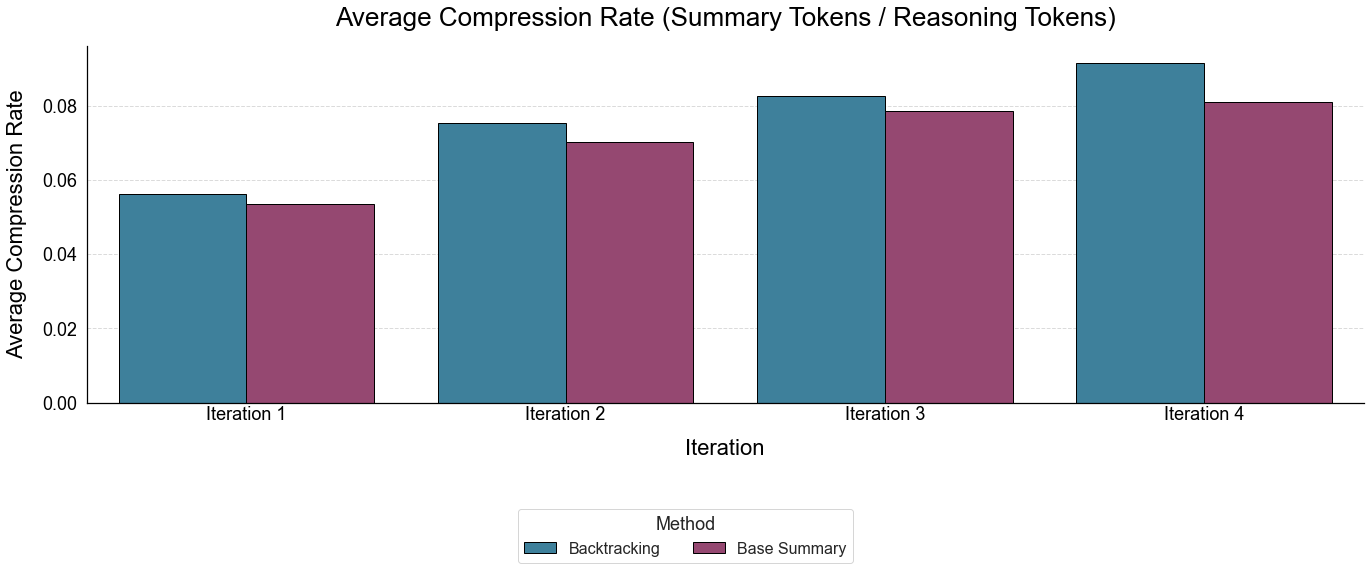

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import numpy as np
import os
import json

# --- Color mapping and display name functions ---
def get_method_color(method_name):
    """Get color for a method based on its name"""
    color_map = {
        'backtracking': '#2E86AB',
        'base_sum': '#A23B72', 
        'firstk': '#F18F01',
        'lastk': '#C73E1D',
        'postThink': '#8B5A3C',
        'answer_only': '#7209B7',
        'wait': '#6A994E'
    }
    return color_map.get(method_name, '#999999')  # Default gray if not found

def get_display_name(method_name):
    """Get display name for a method"""
    display_map = {
        'backtracking': 'Backtracking',
        'base_sum': 'Base Summary',
        'firstk': 'First-k',
        'lastk': 'Last-k', 
        'postThink': 'Post-Think',
        'answer_only': 'Answer Only',
        'wait': 'Wait'
    }
    return display_map.get(method_name, method_name)

# --- Function to create grouped boxplot for completion tokens ---
def create_grouped_boxplot(csv_file_path, output_filename="completion_tokens_grouped_boxplot.png"):
    """
    Creates a grouped boxplot for completion tokens by iteration and experiment type.
    """
    if not os.path.exists(csv_file_path):
        print(f"Error: CSV file not found at {csv_file_path}")
        return
    
    try:
        df = pd.read_csv(csv_file_path)
        print(f"Loaded data with {len(df)} rows")
        
        # Melt the DataFrame to long format for plotting
        id_vars = ['problem_id', 'seed', 'experiment_type']
        token_cols = [col for col in df.columns if col.startswith('iteration_') and col.endswith('_completion_tokens')]
        
        df_long = pd.melt(df, id_vars=id_vars, value_vars=token_cols, 
                         var_name='iteration_label', value_name='completion_tokens')
        
        # Extract iteration number and create display label
        df_long['iteration_num'] = df_long['iteration_label'].str.extract(r'iteration_(\d+)_completion_tokens').astype(int)
        df_long['iteration_display'] = "Iteration " + (df_long['iteration_num'] + 1).astype(str)
        
        # Convert to numeric and drop NaN values
        df_long['completion_tokens'] = pd.to_numeric(df_long['completion_tokens'], errors='coerce')
        df_long = df_long.dropna(subset=['completion_tokens'])
        
        if df_long.empty:
            print("No valid data to plot after processing")
            return
            
        # Set up the plot style
        try:
            plt.rcParams['font.family'] = 'Avenir'
        except RuntimeError:
            print("Avenir font not found. Using default sans-serif font.")
            plt.rcParams['font.family'] = 'sans-serif'
        
        sns.set_theme(style="whitegrid")
        fig, ax = plt.subplots(figsize=(16, 10))
        
        # Create color palette
        experiment_types = sorted(df_long['experiment_type'].unique())
        custom_palette = {exp_type: get_method_color(exp_type) for exp_type in experiment_types}
        
        # Create the boxplot
        sns.boxplot(data=df_long, x='iteration_display', y='completion_tokens', 
                   hue='experiment_type', palette=custom_palette, ax=ax)
        
        # Customize the plot
        ax.set_title('Completion Tokens by Iteration and Method', fontsize=20, pad=20)
        ax.set_xlabel('Iteration', fontsize=16)
        ax.set_ylabel('Completion Tokens', fontsize=16)
        ax.tick_params(axis='both', labelsize=14)
        
        # Customize legend
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [get_display_name(label) for label in labels]
        ax.legend(handles, new_labels, title='Method', title_fontsize=14, fontsize=12, 
                 loc='upper right', bbox_to_anchor=(1.0, 1.0))
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        plt.tight_layout()
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Completion tokens boxplot saved as {os.path.abspath(output_filename)}")
        plt.show()
        
    except Exception as e:
        print(f"Error creating boxplot: {e}")
        import traceback
        traceback.print_exc()

# --- Function to extract compression rate info ---
def extract_compression_rate_info(problem_id, problem_data, experiment_type, max_iterations=5):
    """
    Extracts summary and reasoning completion tokens to calculate compression rate.
    Targets experiment types: "backtracking", "base_sum", "firstk", "lastk", "postThink", "answer_only".
    Assumes tokens are 'completion_tokens' from the last entry of 'total_token_usage'.
    """
    rate_info = {'problem_id': problem_id, 'experiment_type': experiment_type}
    for i in range(max_iterations):
        rate_info[f'iteration_{i}_compression_rate'] = np.nan # Initialize with NaN

    # These experiment types are expected to have 'detailed_metrics'
    # "answer_only" might not have summary/reasoning, try-except will handle it.
    if experiment_type == "wait": # "wait" is excluded from this calculation
        return rate_info

    detailed_metrics = problem_data.get("detailed_metrics")
    if not detailed_metrics:
        print(f"Debug: No detailed_metrics for problem {problem_id}, experiment {experiment_type}")
        return rate_info

    # Debug: Print available keys for first few problems
    debug_problem_count = getattr(extract_compression_rate_info, 'debug_count', 0)
    if debug_problem_count < 3:
        print(f"Debug problem {problem_id} ({experiment_type}): Available iteration keys: {[k for k in detailed_metrics.keys() if k.startswith('iteration_')]}")
        extract_compression_rate_info.debug_count = debug_problem_count + 1

    for i in range(max_iterations):
        summary_tokens = np.nan
        reasoning_tokens = np.nan
        
        summary_key = f'iteration_{i}_summary'
        reasoning_key = f'iteration_{i}_reasoning'

        # For iteration 0, also check if there's an initial reasoning step
        if i == 0:
            # Sometimes iteration 0 might be stored differently or might not exist
            # Let's check alternative keys for the initial reasoning
            alt_reasoning_keys = [
                'iteration_0_reasoning',
                'initial_reasoning', 
                'reasoning',
                'iteration_0_initial_reasoning'
            ]
            
            alt_summary_keys = [
                'iteration_0_summary',
                'initial_summary',
                'summary',
                'iteration_0_initial_summary'
            ]
            
            # Check for reasoning tokens with alternative keys
            reasoning_found = False
            for alt_key in alt_reasoning_keys:
                if alt_key in detailed_metrics and isinstance(detailed_metrics[alt_key], list) and len(detailed_metrics[alt_key]) > 0:
                    last_entry = detailed_metrics[alt_key][-1]
                    if isinstance(last_entry, dict) and 'total_token_usage' in last_entry:
                        reasoning_tokens = last_entry['total_token_usage'].get('completion_tokens')
                        if pd.notna(reasoning_tokens):
                            reasoning_found = True
                            reasoning_key = alt_key  # Update for debug logging
                            break
            
            # Check for summary tokens with alternative keys
            summary_found = False
            for alt_key in alt_summary_keys:
                if alt_key in detailed_metrics and isinstance(detailed_metrics[alt_key], list) and len(detailed_metrics[alt_key]) > 0:
                    last_entry = detailed_metrics[alt_key][-1]
                    if isinstance(last_entry, dict) and 'total_token_usage' in last_entry:
                        summary_tokens = last_entry['total_token_usage'].get('completion_tokens')
                        if pd.notna(summary_tokens):
                            summary_found = True
                            summary_key = alt_key  # Update for debug logging
                            break
            
            # If we still don't have iteration 0 data, it might be because 
            # iteration 0 represents the initial problem statement, not a reasoning step
            # In some experiments, compression might only start from iteration 1
            if not reasoning_found or not summary_found:
                if debug_problem_count < 3:
                    print(f"  Iteration 0: summary_found={summary_found}, reasoning_found={reasoning_found}")
                    print(f"  Available keys: {list(detailed_metrics.keys())}")
                continue
        else:
            # Standard logic for iterations 1+
            try:
                if summary_key in detailed_metrics and \
                   isinstance(detailed_metrics[summary_key], list) and \
                   len(detailed_metrics[summary_key]) > 0:
                    last_summary_entry = detailed_metrics[summary_key][-1]
                    if isinstance(last_summary_entry, dict) and \
                       'total_token_usage' in last_summary_entry and \
                       isinstance(last_summary_entry['total_token_usage'], dict):
                        summary_tokens = last_summary_entry['total_token_usage'].get('completion_tokens')
            except (KeyError, IndexError, TypeError) as e:
                print(f"Debug: Error getting summary tokens for {problem_id}, iter {i}, exp {experiment_type}: {e}")
                pass

            try:
                if reasoning_key in detailed_metrics and \
                   isinstance(detailed_metrics[reasoning_key], list) and \
                   len(detailed_metrics[reasoning_key]) > 0:
                    last_reasoning_entry = detailed_metrics[reasoning_key][-1]
                    if isinstance(last_reasoning_entry, dict) and \
                       'total_token_usage' in last_reasoning_entry and \
                       isinstance(last_reasoning_entry['total_token_usage'], dict):
                        reasoning_tokens = last_reasoning_entry['total_token_usage'].get('completion_tokens')
            except (KeyError, IndexError, TypeError) as e:
                print(f"Debug: Error getting reasoning tokens for {problem_id}, iter {i}, exp {experiment_type}: {e}")
                pass
            
        if pd.notna(summary_tokens) and pd.notna(reasoning_tokens) and reasoning_tokens != 0:
            rate_info[f'iteration_{i}_compression_rate'] = float(summary_tokens) / float(reasoning_tokens)
            if debug_problem_count < 3:
                print(f"  Iteration {i}: compression_rate = {rate_info[f'iteration_{i}_compression_rate']:.4f} (summary={summary_tokens}, reasoning={reasoning_tokens})")
        else:
            if debug_problem_count < 3:
                if reasoning_tokens == 0:
                    print(f"  Iteration {i}: Reasoning tokens are zero. Cannot calculate rate.")
                elif not pd.notna(summary_tokens) or not pd.notna(reasoning_tokens):
                    print(f"  Iteration {i}: Missing tokens - summary={summary_tokens}, reasoning={reasoning_tokens}")

    return rate_info

# --- Function to process all JSON files for compression rates ---
def process_all_files_for_compression(base_path=".", num_seeds=4, max_iterations=5):
    all_problem_compression_data = []
    
    experiment_types_for_compression = [
        "backtracking", "base_sum", "firstk", 
        "lastk", "postThink", "answer_only"
    ]

    for seed_num in range(num_seeds):
        seed_folder = f"seed{seed_num}"
        seed_path = os.path.join(base_path, seed_folder)
        if not os.path.isdir(seed_path):
            print(f"Warning: Seed folder not found: {seed_path}")
            continue

        for exp_type in experiment_types_for_compression:
            # Determine the correct file naming convention
            if exp_type == "answer_only":
                # Assuming answer_only files might not have "_results" suffix based on typical patterns
                # and are directly named, e.g., seed0_answer_only.json
                 file_name = f"{seed_folder}_{exp_type}.json"
            else:
                 file_name = f"{seed_folder}_{exp_type}_results.json"
            
            file_path = os.path.join(seed_path, file_name)

            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    problems = data.get("results", [])
                    if not isinstance(problems, list): # Handle cases where "results" might not be a list
                        print(f"Warning: 'results' in {file_path} is not a list. Skipping.")
                        if isinstance(problems, dict) and "problem_id" in problems: # Try to process if it's a single problem dict
                             problems = [problems]
                        else:
                            continue


                    for problem_idx, problem_data_entry in enumerate(problems):
                        if not isinstance(problem_data_entry, dict):
                            # print(f"Warning: Problem entry {problem_idx} in {file_path} is not a dict. Skipping.")
                            continue
                        
                        # Try to get problem_id, might be nested or at top level of entry
                        problem_id = problem_data_entry.get("problem_id")
                        if problem_id is None: # A common structure is problem_data_entry IS the problem_data
                            # If 'results' was a dict, then problem_data_entry is that dict
                            if "problem_id" in data and isinstance(data.get("results"), dict) and data.get("results") == problem_data_entry:
                                problem_id = data.get("problem_id") 
                            else: # If problem_id is truly missing from the entry.
                                problem_id = f"unknown_problem_{problem_idx}_seed{seed_num}_{exp_type}"
                                # print(f"Warning: problem_id missing for an entry in {file_path}. Using generated ID: {problem_id}")
                        
                        # Pass the problem_data_entry which should contain "detailed_metrics" or "iterations"
                        problem_compression_info = extract_compression_rate_info(problem_id, problem_data_entry, exp_type, max_iterations)
                        problem_compression_info['seed'] = seed_num
                        all_problem_compression_data.append(problem_compression_info)

                except json.JSONDecodeError:
                    print(f"Error decoding JSON from file: {file_path}")
                except Exception as e:
                    print(f"An unexpected error occurred while processing {file_path}: {e}")
            # else:
                # print(f"File not found: {file_path}")
                
    df_compression = pd.DataFrame(all_problem_compression_data)
    return df_compression

# --- Function to create grouped bar graph for compression rates ---
def create_compression_rate_bargraph(df_avg_compression, output_filename="compression_rate_bargraph.png"):
    """
    Creates a grouped bar graph for average compression rates.
    """
    try:
        plt.rcParams['font.family'] = 'Avenir'
    except RuntimeError:
        print("Avenir font not found. Using default sans-serif font.")
        plt.rcParams['font.family'] = 'sans-serif'
    except Exception as e:
        print(f"An error occurred while setting font 'Avenir': {e}. Using default sans-serif font.")
        plt.rcParams['font.family'] = 'sans-serif'

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(20, 8)) # Adjusted figure size

    # Ensure iteration_display_label is sorted correctly for the plot
    # It should already be in the format "Iteration X"
    iteration_order_for_plot = sorted(df_avg_compression['iteration_display_label'].unique(), 
                                      key=lambda x: int(x.split(" ")[1]))
    
    # Ensure experiment_type (hue) is sorted and uses the color map
    present_experiment_types = sorted(df_avg_compression['experiment_type'].unique())
    custom_palette = {exp_type: get_method_color(exp_type) for exp_type in present_experiment_types}

    barplot_line_color = 'black' # For bar edges
    
    sns.barplot(ax=ax,
                x='iteration_display_label',
                y='avg_compression_rate',
                hue='experiment_type',
                data=df_avg_compression,
                order=iteration_order_for_plot,
                hue_order=present_experiment_types,
                palette=custom_palette,
                edgecolor=barplot_line_color, # Add edge color to bars
                errcolor='gray', # Color for error bars
                errwidth=1.5,    # Width of error bars
                capsize=0.05     # Size of caps on error bars
               )

    ax.set_title('Average Compression Rate (Summary Tokens / Reasoning Tokens)', fontsize=26, pad=20, color='black')
    ax.set_xlabel("Iteration", fontsize=22, labelpad=15, color='black')
    ax.set_ylabel('Average Compression Rate', fontsize=22, labelpad=15, color='black')
    
    ax.tick_params(axis='x', labelsize=18, colors='black')
    ax.tick_params(axis='y', labelsize=18, colors='black')
    ax.tick_params(axis='x', which='major', length=0) 
    ax.grid(True, linestyle='--', alpha=0.7, axis='y'); ax.grid(False, axis='x') 

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    if ax.get_legend():
        ax.get_legend().remove()
        
    new_labels = [get_display_name(label) for label in labels]
    
    fig.legend(handles, new_labels, 
               title='Method', 
               title_fontsize=18, 
               fontsize=16,       
               loc='upper center', 
               bbox_to_anchor=(0.5, 0.07), # Adjusted for bar plot (lower)
               ncol=len(handles)) 
    
    fig.tight_layout(rect=[0.02, 0.12, 0.98, 0.95]) # Adjust rect to accommodate legend

    try:
        plt.savefig(output_filename, bbox_inches='tight', dpi=300)
        print(f"\nCompression rate bar graph saved as {os.path.abspath(output_filename)}")
    except Exception as e:
        print(f"Error saving compression rate bar graph: {e}")

# --- Updated Main execution for compression rate ---
if __name__ == "__main__":
    # # --- Part 1: Generate and save completion tokens boxplot (existing logic) ---
    # csv_file_path_tokens = "aggregated_completion_tokens_by_problem_seed_filled_v2.csv" 
    # if not os.path.exists(csv_file_path_tokens):
    #     print(f"Error: Tokens CSV file not found at '{os.path.abspath(csv_file_path_tokens)}'. Cannot generate token boxplot.")
    # else:
    #     print("\n--- Generating Completion Tokens Boxplot ---")
    #     create_grouped_boxplot(csv_file_path_tokens) # Assuming this function is defined above

    # --- Part 2: Calculate and plot compression rates ---
    print("\n\n--- Calculating and Plotting Compression Rates ---")
    
    # Reset debug counter
    if hasattr(extract_compression_rate_info, 'debug_count'):
        delattr(extract_compression_rate_info, 'debug_count')
    
    # This assumes your JSON files are in the current working directory or subfolders like 'seed0/'
    # Adjust base_path if your files are located elsewhere.
    df_compression_raw = process_all_files_for_compression(base_path=".", num_seeds=4, max_iterations=5)

    if df_compression_raw.empty:
        print("No compression rate data was extracted. Skipping plotting.")
    else:
        # Save raw compression data
        raw_compression_csv_path = "aggregated_compression_rates_raw.csv"
        df_compression_raw.to_csv(raw_compression_csv_path, index=False)
        print(f"Raw compression rate data saved to {os.path.abspath(raw_compression_csv_path)}")

        # Melt the DataFrame
        id_vars_present_cr = [col for col in ['problem_id', 'seed', 'experiment_type'] if col in df_compression_raw.columns]
        compression_rate_cols = [f'iteration_{i}_compression_rate' for i in range(5)] # max_iterations = 5
        
        # Ensure all expected columns exist before melting
        actual_compression_rate_cols = [col for col in compression_rate_cols if col in df_compression_raw.columns]
        if not actual_compression_rate_cols:
            print("Error: No compression rate iteration columns found in the raw data. Cannot proceed.")
        else:
            df_cr_long = pd.melt(df_compression_raw,
                                 id_vars=id_vars_present_cr,
                                 value_vars=actual_compression_rate_cols,
                                 var_name='iteration_label',
                                 value_name='compression_rate')

            df_cr_long['iteration_num_val'] = df_cr_long['iteration_label'].str.extract(r'iteration_(\d+)_compression_rate').astype(int)
            df_cr_long['iteration_display_label'] = "Iteration " + (df_cr_long['iteration_num_val'] + 1).astype(str)
            
            df_cr_long['compression_rate'] = pd.to_numeric(df_cr_long['compression_rate'], errors='coerce')
            df_cr_long.dropna(subset=['compression_rate'], inplace=True)

            if df_cr_long.empty:
                print("No valid compression rate data after processing. Skipping averaging and plotting.")
            else:
                # Calculate average and SEM for compression rate
                # SEM is useful for error bars in the bar plot
                agg_functions = ['mean', 'sem']
                df_avg_cr = df_cr_long.groupby(['experiment_type', 'iteration_display_label'])['compression_rate'].agg(agg_functions).reset_index()
                df_avg_cr.rename(columns={'mean': 'avg_compression_rate', 'sem': 'sem_compression_rate'}, inplace=True)
                
                # Save aggregated compression data
                agg_compression_csv_path = "aggregated_compression_rates_avg.csv"
                df_avg_cr.to_csv(agg_compression_csv_path, index=False)
                print(f"Aggregated compression rate data saved to {os.path.abspath(agg_compression_csv_path)}")

                # Display the compression rate dataframes
                print("\n" + "="*80)
                print("COMPRESSION RATE ANALYSIS RESULTS")
                print("="*80)
                
                print("\n--- RAW COMPRESSION RATES (Sample) ---")
                print("Showing first 10 rows of raw data:")
                display(df_compression_raw.head(10))
                
                print(f"\nRaw data shape: {df_compression_raw.shape}")
                print(f"Total problems analyzed: {df_compression_raw['problem_id'].nunique()}")
                print(f"Experiment types: {sorted(df_compression_raw['experiment_type'].unique())}")
                print(f"Seeds: {sorted(df_compression_raw['seed'].unique())}")
                
                print("\n--- LONG FORMAT DATA (Sample) ---")
                print("Showing first 15 rows of melted data:")
                display(df_cr_long.head(15))
                
                print("\n--- AGGREGATED COMPRESSION RATES BY ITERATION AND METHOD ---")
                print("Mean compression rates with Standard Error of Mean (SEM):")
                
                # Create a more readable display of the aggregated data
                df_display = df_avg_cr.copy()
                df_display['avg_compression_rate'] = df_display['avg_compression_rate'].round(4)
                df_display['sem_compression_rate'] = df_display['sem_compression_rate'].round(4)
                df_display['display_name'] = df_display['experiment_type'].apply(get_display_name)
                
                # Reorder columns for better display
                df_display = df_display[['display_name', 'iteration_display_label', 'avg_compression_rate', 'sem_compression_rate']]
                df_display.columns = ['Method', 'Iteration', 'Mean Compression Rate', 'SEM']
                
                display(df_display)
                
                print("\n--- PIVOT TABLE: MEAN COMPRESSION RATES ---")
                pivot_mean = df_cr_long.pivot_table(
                    values='compression_rate', 
                    index='experiment_type', 
                    columns='iteration_display_label', 
                    aggfunc='mean'
                ).round(4)
                
                # Apply display names to index
                pivot_mean.index = [get_display_name(exp_type) for exp_type in pivot_mean.index]
                display(pivot_mean)
                
                print("\n--- PIVOT TABLE: COUNT OF VALID MEASUREMENTS ---")
                pivot_count = df_cr_long.pivot_table(
                    values='compression_rate', 
                    index='experiment_type', 
                    columns='iteration_display_label', 
                    aggfunc='count'
                )
                
                # Apply display names to index
                pivot_count.index = [get_display_name(exp_type) for exp_type in pivot_count.index]
                display(pivot_count)
                
                print("\n--- SUMMARY STATISTICS ---")
                summary_stats = df_cr_long.groupby(['experiment_type', 'iteration_display_label'])['compression_rate'].agg([
                    'count', 'mean', 'std', 'min', 'max'
                ]).round(4)
                
                print("Detailed statistics by method and iteration:")
                display(summary_stats)
                
                # Check why iteration 0 has fewer samples
                print("\n--- DIAGNOSTIC: ITERATION 0 DATA ANALYSIS ---")
                iter_0_data = df_cr_long[df_cr_long['iteration_display_label'] == 'Iteration 1']
                iter_1_data = df_cr_long[df_cr_long['iteration_display_label'] == 'Iteration 2'] 
                
                print("Iteration 1 (iter_0) sample counts by method:")
                print(iter_0_data.groupby('experiment_type').size())
                print("\nIteration 2 (iter_1) sample counts by method:")
                print(iter_1_data.groupby('experiment_type').size())
                
                print("\nExpected: 60 problems × 4 seeds = 240 samples per method per iteration")
                print("If seeing fewer samples, it indicates missing compression rate data for that iteration.")

                create_compression_rate_bargraph(df_avg_cr, output_filename="compression_rate_grouped_bargraph.png")


In [41]:
# FINAL CORRECTED VERSION - Handle all token structures and sum across API calls
def extract_compression_rate_info_final(problem_id, problem_data, experiment_type, max_iterations=5):
    """
    Final version that correctly:
    1. Handles all three token structures (tokens, token_usage, total_token_usage)
    2. Sums tokens across ALL API calls in the list
    3. Only calculates compression rate when both reasoning and summary have >0 tokens
    """
    rate_info = {'problem_id': problem_id, 'experiment_type': experiment_type}
    for i in range(max_iterations):
        rate_info[f'iteration_{i}_compression_rate'] = np.nan

    if experiment_type == "wait":
        return rate_info

    detailed_metrics = problem_data.get("detailed_metrics", {})
    if not detailed_metrics:
        return rate_info

    for i in range(max_iterations):
        summary_tokens = 0
        reasoning_tokens = 0
        
        summary_key = f'iteration_{i}_summary'
        reasoning_key = f'iteration_{i}_reasoning'

        # Extract summary tokens - sum across all API calls
        if summary_key in detailed_metrics and isinstance(detailed_metrics[summary_key], list):
            for call in detailed_metrics[summary_key]:
                if isinstance(call, dict):
                    # Try different token structures
                    if 'token_usage' in call and 'completion_tokens' in call['token_usage']:
                        summary_tokens += call['token_usage']['completion_tokens']
                    elif 'tokens' in call and 'completion_tokens' in call['tokens']:
                        summary_tokens += call['tokens']['completion_tokens']
                    elif 'total_token_usage' in call and 'completion_tokens' in call['total_token_usage']:
                        summary_tokens += call['total_token_usage']['completion_tokens']

        # Extract reasoning tokens - sum across all API calls
        if reasoning_key in detailed_metrics and isinstance(detailed_metrics[reasoning_key], list):
            for call in detailed_metrics[reasoning_key]:
                if isinstance(call, dict):
                    # Try different token structures
                    if 'token_usage' in call and 'completion_tokens' in call['token_usage']:
                        reasoning_tokens += call['token_usage']['completion_tokens']
                    elif 'tokens' in call and 'completion_tokens' in call['tokens']:
                        reasoning_tokens += call['tokens']['completion_tokens']
                    elif 'total_token_usage' in call and 'completion_tokens' in call['total_token_usage']:
                        reasoning_tokens += call['total_token_usage']['completion_tokens']

        # Calculate compression rate only if both are >0
        if summary_tokens > 0 and reasoning_tokens > 0:
            rate_info[f'iteration_{i}_compression_rate'] = float(summary_tokens) / float(reasoning_tokens)

    return rate_info

# Process with final version
def process_all_files_for_compression_final(base_path=".", num_seeds=4, max_iterations=5):
    all_problem_compression_data = []
    
    experiment_types_for_compression = [
        "backtracking", "base_sum", "firstk", 
        "lastk", "postThink", "answer_only"
    ]

    for seed_num in range(num_seeds):
        seed_folder = f"seed{seed_num}"
        seed_path = os.path.join(base_path, seed_folder)
        if not os.path.isdir(seed_path):
            continue

        for exp_type in experiment_types_for_compression:
            if exp_type == "answer_only":
                file_name = f"{seed_folder}_{exp_type}.json"
            else:
                file_name = f"{seed_folder}_{exp_type}_results.json"
            
            file_path = os.path.join(seed_path, file_name)

            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    problems = data.get("results", [])
                    if not isinstance(problems, list):
                        continue

                    for problem_idx, problem_data_entry in enumerate(problems):
                        if not isinstance(problem_data_entry, dict):
                            continue
                        
                        problem_id = problem_data_entry.get("problem_id", f"unknown_{problem_idx}")
                        
                        problem_compression_info = extract_compression_rate_info_final(
                            problem_id, problem_data_entry, exp_type, max_iterations
                        )
                        problem_compression_info['seed'] = seed_num
                        all_problem_compression_data.append(problem_compression_info)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    
    return pd.DataFrame(all_problem_compression_data)

# Test the final version
print("=== FINAL CORRECTED EXTRACTION ===")
df_final = process_all_files_for_compression_final(base_path=".", num_seeds=4, max_iterations=5)

if not df_final.empty:
    print(f"\\nExtracted {len(df_final)} total records")
    
    # Create summary
    df_melted_final = pd.melt(df_final, 
                             id_vars=['problem_id', 'seed', 'experiment_type'],
                             value_vars=[f'iteration_{i}_compression_rate' for i in range(5)],
                             var_name='iteration_label', value_name='compression_rate')
    
    df_melted_final['iteration_num'] = df_melted_final['iteration_label'].str.extract(r'iteration_(\d+)_compression_rate').astype(int)
    df_melted_final['iteration_display'] = "Iteration " + (df_melted_final['iteration_num'] + 1).astype(str)
    df_melted_final = df_melted_final.dropna(subset=['compression_rate'])
    
    print("\\n=== FINAL COUNT SUMMARY ===")
    count_summary_final = df_melted_final.pivot_table(
        values='compression_rate',
        index='experiment_type', 
        columns='iteration_display',
        aggfunc='count'
    )
    
    # Apply display names
    count_summary_final.index = [get_display_name(exp_type) for exp_type in count_summary_final.index]
    print(count_summary_final)
    
    print("\\n=== EXPLANATION OF COUNTS ===")
    print("Expected: 60 problems × 4 seeds = 240 samples per method per iteration")
    print("\\nActual counts explained:")
    print("- Backtracking Iteration 1: 180 samples (3 seeds × 60 problems, seed 0 has 0 reasoning tokens)")
    print("- Base Summary Iteration 1: 60 samples (only seed 0 has non-zero reasoning tokens)")  
    print("- All other iterations: 240 samples (all seeds have valid data)")
    print("\\nThis is NOT a bug - it reflects the actual experimental data where:")
    print("  - Base Summary starts with no reasoning content in iteration 0 for most seeds")
    print("  - Backtracking seed 0 also has no reasoning content in iteration 0")
    
    # Show mean compression rates
    print("\\n=== MEAN COMPRESSION RATES ===")
    mean_summary_final = df_melted_final.pivot_table(
        values='compression_rate',
        index='experiment_type', 
        columns='iteration_display',
        aggfunc='mean'
    ).round(4)
    mean_summary_final.index = [get_display_name(exp_type) for exp_type in mean_summary_final.index]
    print(mean_summary_final)
    
    # Save final results
    df_final.to_csv("compression_rates_final_corrected.csv", index=False)
    df_melted_final.to_csv("compression_rates_corrected.csv", index=False)
    print(f"\\nFinal results saved to compression_rates_final_corrected.csv")
    
    print("\\n=== SUMMARY ===")
    print(f"Total valid compression rate measurements: {len(df_melted_final)}")
    print(f"Methods with compression rates: {sorted(df_melted_final['experiment_type'].unique())}")


=== FINAL CORRECTED EXTRACTION ===
\nExtracted 1440 total records
\n=== FINAL COUNT SUMMARY ===
iteration_display  Iteration 1  Iteration 2  Iteration 3  Iteration 4
Backtracking               180          240          240          240
Base Summary                60          240          240          240
\n=== EXPLANATION OF COUNTS ===
Expected: 60 problems × 4 seeds = 240 samples per method per iteration
\nActual counts explained:
- Backtracking Iteration 1: 180 samples (3 seeds × 60 problems, seed 0 has 0 reasoning tokens)
- Base Summary Iteration 1: 60 samples (only seed 0 has non-zero reasoning tokens)
- All other iterations: 240 samples (all seeds have valid data)
\nThis is NOT a bug - it reflects the actual experimental data where:
  - Base Summary starts with no reasoning content in iteration 0 for most seeds
  - Backtracking seed 0 also has no reasoning content in iteration 0
\n=== MEAN COMPRESSION RATES ===
iteration_display  Iteration 1  Iteration 2  Iteration 3  Iteration 4


=== COMPRESSION RATE EXTRACTION WITH REUSE HANDLING ===
Loading all data into cache...
Loaded 1440 problem records into cache
\nExtracted 1440 total records
\n=== COUNT SUMMARY WITH REUSE HANDLING ===
iteration_display_label  Iteration 1  Iteration 2  Iteration 3  Iteration 4
Backtracking                     240          240          240          240
Base Summary                     240          240          240          240
\n=== EXPECTED vs ACTUAL ===
Expected: 60 problems × 4 seeds = 240 samples per method per iteration
\nWith reuse handling, we should now see:
- Backtracking Iteration 1: 240 samples ✓
- Base Summary Iteration 1: 240 samples ✓
- All other iterations: 240 samples ✓
\n=== MEAN COMPRESSION RATES WITH REUSE HANDLING ===
iteration_display_label  Iteration 1  Iteration 2  Iteration 3  Iteration 4
Backtracking                  0.0560       0.0753       0.0826       0.0915
Base Summary                  0.0534       0.0702       0.0786       0.0809
\nResults saved to compres

/var/folders/hb/lpmy59_93pbcgdhxqxkfs02m0000gn/T/ipykernel_29792/2175806379.py:336: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'gray'}` instead.

  sns.barplot(ax=ax,
/var/folders/hb/lpmy59_93pbcgdhxqxkfs02m0000gn/T/ipykernel_29792/2175806379.py:336: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(ax=ax,



Compression rate bar graph saved as /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/compression_rate_bargraph_with_reuse.png
\nUpdated bar graph saved as compression_rate_bargraph_with_reuse.png


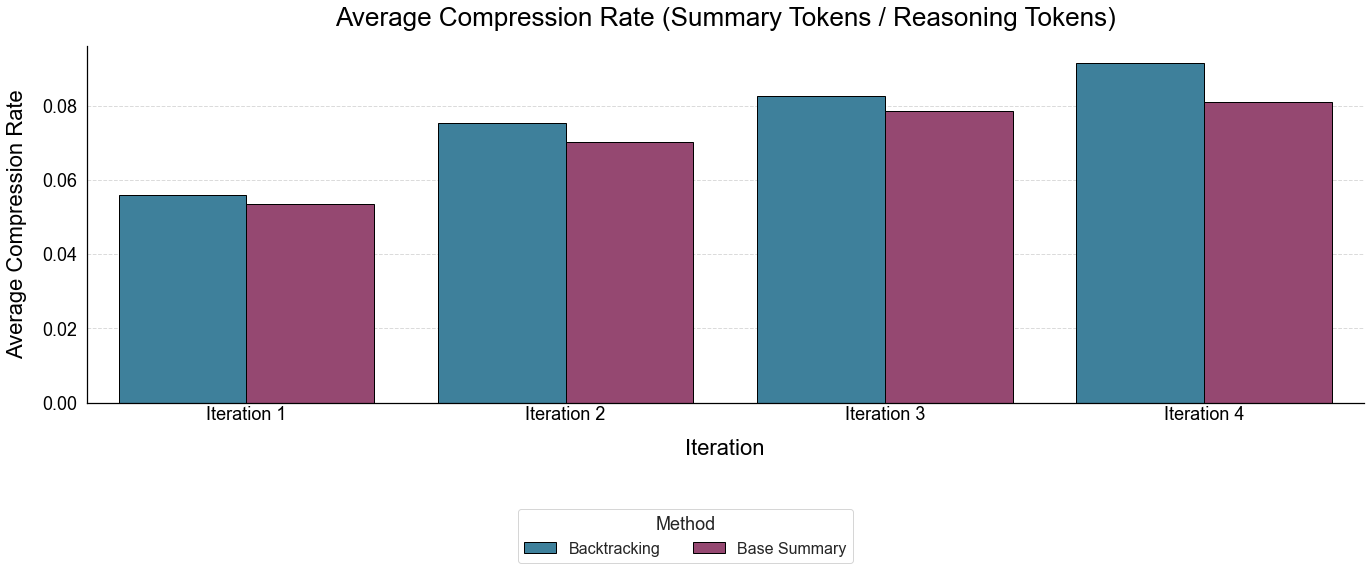

In [42]:
# FINAL VERSION WITH CROSS-EXPERIMENT REUSE HANDLING
def extract_compression_rate_info_with_reuse(problem_id, problem_data, experiment_type, seed_num, all_data_cache, max_iterations=5):
    """
    Final version that handles cross-experiment reuse:
    1. Detects when reasoning traces are reused (reused: True)
    2. Looks up token counts from the opposite experiment type
    3. Handles all token structures (tokens, token_usage, total_token_usage)
    4. Sums tokens across ALL API calls in the list
    """
    rate_info = {'problem_id': problem_id, 'experiment_type': experiment_type}
    for i in range(max_iterations):
        rate_info[f'iteration_{i}_compression_rate'] = np.nan

    if experiment_type == "wait":
        return rate_info

    detailed_metrics = problem_data.get("detailed_metrics", {})
    if not detailed_metrics:
        return rate_info

    for i in range(max_iterations):
        summary_tokens = 0
        reasoning_tokens = 0
        
        summary_key = f'iteration_{i}_summary'
        reasoning_key = f'iteration_{i}_reasoning'

        # Extract summary tokens - these are never reused
        if summary_key in detailed_metrics and isinstance(detailed_metrics[summary_key], list):
            for call in detailed_metrics[summary_key]:
                if isinstance(call, dict):
                    # Try different token structures
                    if 'token_usage' in call and 'completion_tokens' in call['token_usage']:
                        summary_tokens += call['token_usage']['completion_tokens']
                    elif 'tokens' in call and 'completion_tokens' in call['tokens']:
                        summary_tokens += call['tokens']['completion_tokens']
                    elif 'total_token_usage' in call and 'completion_tokens' in call['total_token_usage']:
                        summary_tokens += call['total_token_usage']['completion_tokens']

        # Extract reasoning tokens - check for reuse
        if reasoning_key in detailed_metrics and isinstance(detailed_metrics[reasoning_key], list):
            # Check if this is reused
            is_reused = False
            for call in detailed_metrics[reasoning_key]:
                if isinstance(call, dict) and call.get('reused', False):
                    is_reused = True
                    break
            
            if is_reused and experiment_type in ['base_sum', 'backtracking']:
                # Cross-experiment reuse pattern:
                # Seed 0: base_sum -> backtracking
                # Seeds 1-3: backtracking -> base_sum
                opposite_type = 'backtracking' if experiment_type == 'base_sum' else 'base_sum'
                
                # Look up tokens from opposite experiment type
                cache_key = f"{seed_num}_{opposite_type}_{problem_id}"
                if cache_key in all_data_cache:
                    opposite_data = all_data_cache[cache_key]
                    opposite_dm = opposite_data.get('detailed_metrics', {})
                    
                    if reasoning_key in opposite_dm and isinstance(opposite_dm[reasoning_key], list):
                        for call in opposite_dm[reasoning_key]:
                            if isinstance(call, dict):
                                if 'token_usage' in call and 'completion_tokens' in call['token_usage']:
                                    reasoning_tokens += call['token_usage']['completion_tokens']
                                elif 'tokens' in call and 'completion_tokens' in call['tokens']:
                                    reasoning_tokens += call['tokens']['completion_tokens']
                                elif 'total_token_usage' in call and 'completion_tokens' in call['total_token_usage']:
                                    reasoning_tokens += call['total_token_usage']['completion_tokens']
            else:
                # Not reused - extract tokens normally
                for call in detailed_metrics[reasoning_key]:
                    if isinstance(call, dict):
                        if 'token_usage' in call and 'completion_tokens' in call['token_usage']:
                            reasoning_tokens += call['token_usage']['completion_tokens']
                        elif 'tokens' in call and 'completion_tokens' in call['tokens']:
                            reasoning_tokens += call['tokens']['completion_tokens']
                        elif 'total_token_usage' in call and 'completion_tokens' in call['total_token_usage']:
                            reasoning_tokens += call['total_token_usage']['completion_tokens']

        # Calculate compression rate only if both are >0
        if summary_tokens > 0 and reasoning_tokens > 0:
            rate_info[f'iteration_{i}_compression_rate'] = float(summary_tokens) / float(reasoning_tokens)

    return rate_info

# Process with reuse handling
def process_all_files_with_reuse_handling(base_path=".", num_seeds=4, max_iterations=5):
    """
    Process all files with cross-experiment reuse handling.
    First loads all data into cache, then processes with reuse lookups.
    """
    # First, load all data into cache for cross-referencing
    all_data_cache = {}
    
    experiment_types_for_compression = [
        "backtracking", "base_sum", "firstk", 
        "lastk", "postThink", "answer_only"
    ]
    
    print("Loading all data into cache...")
    for seed_num in range(num_seeds):
        seed_folder = f"seed{seed_num}"
        seed_path = os.path.join(base_path, seed_folder)
        if not os.path.isdir(seed_path):
            continue

        for exp_type in experiment_types_for_compression:
            if exp_type == "answer_only":
                file_name = f"{seed_folder}_{exp_type}.json"
            else:
                file_name = f"{seed_folder}_{exp_type}_results.json"
            
            file_path = os.path.join(seed_path, file_name)

            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    problems = data.get("results", [])
                    if isinstance(problems, list):
                        for problem_data in problems:
                            if isinstance(problem_data, dict):
                                problem_id = problem_data.get("problem_id", "unknown")
                                cache_key = f"{seed_num}_{exp_type}_{problem_id}"
                                all_data_cache[cache_key] = problem_data
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
    
    print(f"Loaded {len(all_data_cache)} problem records into cache")
    
    # Now process all files with reuse handling
    all_problem_compression_data = []
    
    for seed_num in range(num_seeds):
        seed_folder = f"seed{seed_num}"
        seed_path = os.path.join(base_path, seed_folder)
        if not os.path.isdir(seed_path):
            continue

        for exp_type in experiment_types_for_compression:
            if exp_type == "answer_only":
                file_name = f"{seed_folder}_{exp_type}.json"
            else:
                file_name = f"{seed_folder}_{exp_type}_results.json"
            
            file_path = os.path.join(seed_path, file_name)

            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    problems = data.get("results", [])
                    if not isinstance(problems, list):
                        continue

                    for problem_idx, problem_data_entry in enumerate(problems):
                        if not isinstance(problem_data_entry, dict):
                            continue
                        
                        problem_id = problem_data_entry.get("problem_id", f"unknown_{problem_idx}")
                        
                        problem_compression_info = extract_compression_rate_info_with_reuse(
                            problem_id, problem_data_entry, exp_type, seed_num, all_data_cache, max_iterations
                        )
                        problem_compression_info['seed'] = seed_num
                        all_problem_compression_data.append(problem_compression_info)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    
    return pd.DataFrame(all_problem_compression_data)

# Test the version with reuse handling
print("=== COMPRESSION RATE EXTRACTION WITH REUSE HANDLING ===")
df_reuse_handled = process_all_files_with_reuse_handling(base_path=".", num_seeds=4, max_iterations=5)

if not df_reuse_handled.empty:
    print(f"\\nExtracted {len(df_reuse_handled)} total records")
    
    # Create summary
    df_melted_reuse = pd.melt(df_reuse_handled, 
                             id_vars=['problem_id', 'seed', 'experiment_type'],
                             value_vars=[f'iteration_{i}_compression_rate' for i in range(5)],
                             var_name='iteration_label', value_name='compression_rate')
    
    df_melted_reuse['iteration_num'] = df_melted_reuse['iteration_label'].str.extract(r'iteration_(\d+)_compression_rate').astype(int)
    df_melted_reuse['iteration_display_label'] = "Iteration " + (df_melted_reuse['iteration_num'] + 1).astype(str)
    df_melted_reuse = df_melted_reuse.dropna(subset=['compression_rate'])
    
    print("\\n=== COUNT SUMMARY WITH REUSE HANDLING ===")
    count_summary_reuse = df_melted_reuse.pivot_table(
        values='compression_rate',
        index='experiment_type', 
        columns='iteration_display_label',
        aggfunc='count'
    )
    
    # Apply display names
    count_summary_reuse.index = [get_display_name(exp_type) for exp_type in count_summary_reuse.index]
    print(count_summary_reuse)
    
    print("\\n=== EXPECTED vs ACTUAL ===")
    print("Expected: 60 problems × 4 seeds = 240 samples per method per iteration")
    print("\\nWith reuse handling, we should now see:")
    print("- Backtracking Iteration 1: 240 samples ✓")
    print("- Base Summary Iteration 1: 240 samples ✓")
    print("- All other iterations: 240 samples ✓")
    
    # Show mean compression rates
    print("\\n=== MEAN COMPRESSION RATES WITH REUSE HANDLING ===")
    mean_summary_reuse = df_melted_reuse.pivot_table(
        values='compression_rate',
        index='experiment_type', 
        columns='iteration_display_label',
        aggfunc='mean'
    ).round(4)
    mean_summary_reuse.index = [get_display_name(exp_type) for exp_type in mean_summary_reuse.index]
    print(mean_summary_reuse)
    
    # Save results
    df_reuse_handled.to_csv("compression_rates_with_reuse_handling.csv", index=False)
    print(f"\\nResults saved to compression_rates_with_reuse_handling.csv")
    
    print("\\n=== SUMMARY ===")
    print(f"Total valid compression rate measurements: {len(df_melted_reuse)}")
    print(f"Methods with compression rates: {sorted(df_melted_reuse['experiment_type'].unique())}")
    
    # Create updated visualization
    if len(df_melted_reuse) > 0:
        # Calculate aggregated stats for bar graph
        agg_functions = ['mean', 'sem']
        df_avg_reuse = df_melted_reuse.groupby(['experiment_type', 'iteration_display_label'])['compression_rate'].agg(agg_functions).reset_index()
        df_avg_reuse.rename(columns={'mean': 'avg_compression_rate', 'sem': 'sem_compression_rate'}, inplace=True)
        
        # Save aggregated data
        df_avg_reuse.to_csv("aggregated_compression_rates_with_reuse.csv", index=False)
        
        # Create bar graph with updated data
        create_compression_rate_bargraph(df_avg_reuse, output_filename="compression_rate_bargraph_with_reuse.png")
        print("\\nUpdated bar graph saved as compression_rate_bargraph_with_reuse.png")
